# 1. Класифікація одягу (Fashion MNIST):

- Побудувати і навчити нейронну мережу для класифікації зображень одягу з датасету Fashion MNIST.
- Дослідити вплив додаткових шарів та різних функцій активації на точність моделі.

In [61]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip3 install matplotlib
!pip3 install tqdm

Looking in indexes: https://download.pytorch.org/whl/cu124


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
print(f"Training data: {len(training_data)}")
print(f"Test data: {len(test_data)}")

Training data: 60000
Test data: 10000


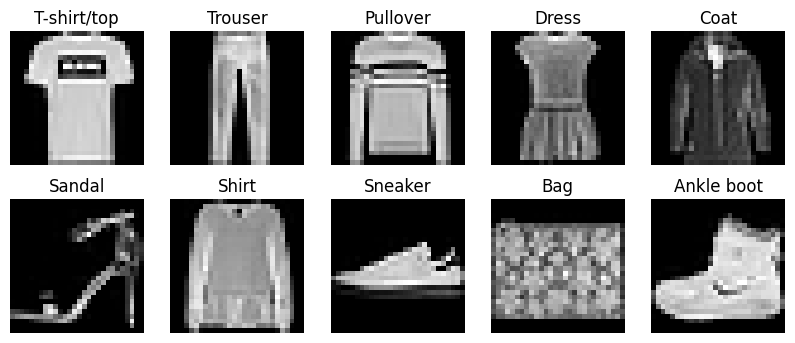

In [5]:
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img, label = next(d for d in training_data if d[1] == i - 1)
    figure.add_subplot(rows, cols, i)
    plt.title(training_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"X: {X.shape}, y: {y.shape}")
    break

X: torch.Size([128, 1, 28, 28]), y: torch.Size([128])


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [8]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    print(f"{total_trainable_params:,} training parameters.")

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader)
    losses = 0

    for X, y in tqdm(dataloader, total=size):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses += loss.item()
    return losses / size

In [10]:
def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader)
    losses, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            losses += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return losses / size, correct / len(dataloader.dataset)

In [11]:
def epoch_time(start_time: int, end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
def train_model(
    model,
    loss_fn,
    optimizer,
    num_epochs,
    *,
    epoch_start=1,
    train_losses=None,
    test_losses=None,
    accuracy=None,
):
    train_losses = train_losses or []
    test_losses = test_losses or []
    accuracy = accuracy or []
    for epoch in range(epoch_start, num_epochs + 1):
        start_time = time.time()
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss, acc = test(test_dataloader, model, loss_fn)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy.append(acc)
        print(
            f"Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f} | Accuracy: {(100*acc):>0.1f}%"
        )

    return train_losses, test_losses, accuracy

In [13]:
def plot_losses(train_losses, test_losses, name):
    plt.figure(figsize=(5, 5))
    plt.plot(train_losses, color="blue", linestyle="-", label="train loss")
    plt.plot(test_losses, color="red", linestyle="-", label="test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join("outputs", f"{name}-losses.png"))
    plt.show()

In [14]:
def plot_accuracy(accuracy, name):
    plt.figure(figsize=(5, 5))
    plt.plot(accuracy, color="blue", linestyle="-", label="accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join("outputs", f"{name}-accuracy.png"))
    plt.show()

In [15]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits


model1 = NeuralNetwork1().to(device)
print(model1)
count_parameters(model1)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters())

NeuralNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
669,706 total parameters.
669,706 training parameters.


In [15]:
results = train_model(model1, loss_fn, optimizer, 30)

100%|██████████| 469/469 [00:10<00:00, 45.68it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 2.279 | Test Loss: 2.249 | Accuracy: 27.7%


100%|██████████| 469/469 [00:09<00:00, 50.71it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 2.214 | Test Loss: 2.176 | Accuracy: 49.9%


100%|██████████| 469/469 [00:08<00:00, 52.13it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 2.126 | Test Loss: 2.073 | Accuracy: 57.1%


100%|██████████| 469/469 [00:09<00:00, 51.25it/s]


Epoch: 04 | Time: 0m 10s | Train Loss: 2.001 | Test Loss: 1.925 | Accuracy: 58.0%


100%|██████████| 469/469 [00:09<00:00, 52.05it/s]


Epoch: 05 | Time: 0m 10s | Train Loss: 1.831 | Test Loss: 1.739 | Accuracy: 58.0%


100%|██████████| 469/469 [00:09<00:00, 52.07it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 1.639 | Test Loss: 1.551 | Accuracy: 60.6%


100%|██████████| 469/469 [00:09<00:00, 51.93it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 1.463 | Test Loss: 1.391 | Accuracy: 61.6%


100%|██████████| 469/469 [00:09<00:00, 51.87it/s]


Epoch: 08 | Time: 0m 10s | Train Loss: 1.319 | Test Loss: 1.265 | Accuracy: 62.8%


100%|██████████| 469/469 [00:09<00:00, 51.69it/s]


Epoch: 09 | Time: 0m 10s | Train Loss: 1.207 | Test Loss: 1.168 | Accuracy: 64.0%


100%|██████████| 469/469 [00:09<00:00, 51.86it/s]


Epoch: 10 | Time: 0m 10s | Train Loss: 1.119 | Test Loss: 1.091 | Accuracy: 64.7%


100%|██████████| 469/469 [00:09<00:00, 51.91it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 1.050 | Test Loss: 1.031 | Accuracy: 65.1%


100%|██████████| 469/469 [00:09<00:00, 51.84it/s]


Epoch: 12 | Time: 0m 10s | Train Loss: 0.996 | Test Loss: 0.983 | Accuracy: 65.6%


100%|██████████| 469/469 [00:09<00:00, 51.95it/s]


Epoch: 13 | Time: 0m 10s | Train Loss: 0.951 | Test Loss: 0.943 | Accuracy: 66.5%


100%|██████████| 469/469 [00:09<00:00, 51.80it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 0.914 | Test Loss: 0.910 | Accuracy: 67.4%


100%|██████████| 469/469 [00:09<00:00, 51.92it/s]


Epoch: 15 | Time: 0m 10s | Train Loss: 0.883 | Test Loss: 0.881 | Accuracy: 68.0%


100%|██████████| 469/469 [00:08<00:00, 52.19it/s]


Epoch: 16 | Time: 0m 10s | Train Loss: 0.856 | Test Loss: 0.857 | Accuracy: 68.4%


100%|██████████| 469/469 [00:09<00:00, 51.83it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 0.833 | Test Loss: 0.836 | Accuracy: 69.1%


100%|██████████| 469/469 [00:09<00:00, 52.01it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 0.813 | Test Loss: 0.818 | Accuracy: 69.6%


100%|██████████| 469/469 [00:09<00:00, 51.58it/s]


Epoch: 19 | Time: 0m 10s | Train Loss: 0.796 | Test Loss: 0.802 | Accuracy: 70.2%


100%|██████████| 469/469 [00:09<00:00, 51.84it/s]


Epoch: 20 | Time: 0m 10s | Train Loss: 0.779 | Test Loss: 0.786 | Accuracy: 70.8%


100%|██████████| 469/469 [00:09<00:00, 51.98it/s]


Epoch: 21 | Time: 0m 10s | Train Loss: 0.765 | Test Loss: 0.773 | Accuracy: 71.7%


100%|██████████| 469/469 [00:09<00:00, 51.94it/s]


Epoch: 22 | Time: 0m 10s | Train Loss: 0.752 | Test Loss: 0.760 | Accuracy: 71.9%


100%|██████████| 469/469 [00:08<00:00, 52.13it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 0.739 | Test Loss: 0.749 | Accuracy: 72.6%


100%|██████████| 469/469 [00:09<00:00, 51.89it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 0.728 | Test Loss: 0.739 | Accuracy: 73.1%


100%|██████████| 469/469 [00:09<00:00, 52.07it/s]


Epoch: 25 | Time: 0m 10s | Train Loss: 0.718 | Test Loss: 0.728 | Accuracy: 73.6%


100%|██████████| 469/469 [00:09<00:00, 51.95it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 0.707 | Test Loss: 0.719 | Accuracy: 74.0%


100%|██████████| 469/469 [00:09<00:00, 51.99it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.698 | Test Loss: 0.710 | Accuracy: 74.6%


100%|██████████| 469/469 [00:08<00:00, 52.25it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 0.689 | Test Loss: 0.700 | Accuracy: 74.9%


100%|██████████| 469/469 [00:08<00:00, 52.21it/s]


Epoch: 29 | Time: 0m 10s | Train Loss: 0.680 | Test Loss: 0.692 | Accuracy: 75.2%


100%|██████████| 469/469 [00:09<00:00, 51.80it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 0.672 | Test Loss: 0.684 | Accuracy: 75.6%


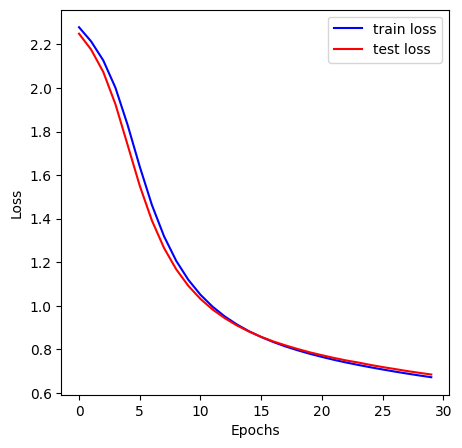

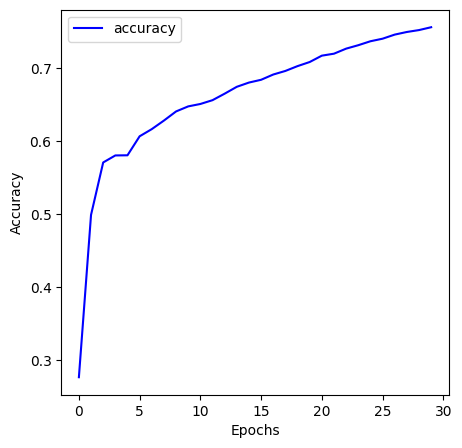

In [16]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn1")
plot_accuracy(accuracy, "nn1")

In [17]:
model1_o2 = NeuralNetwork1().to(device)
optimizer2 = torch.optim.SGD(model1_o2.parameters(), lr=1e-2)
results = train_model(model1_o2, loss_fn, optimizer2, 30)

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:09<00:00, 50.76it/s]


Epoch: 01 | Time: 0m 10s | Train Loss: 1.700 | Test Loss: 1.107 | Accuracy: 62.5%


100%|██████████| 469/469 [00:08<00:00, 53.11it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 0.906 | Test Loss: 0.803 | Accuracy: 70.0%


100%|██████████| 469/469 [00:08<00:00, 52.72it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 0.726 | Test Loss: 0.690 | Accuracy: 76.0%


100%|██████████| 469/469 [00:08<00:00, 53.03it/s]


Epoch: 04 | Time: 0m 10s | Train Loss: 0.641 | Test Loss: 0.630 | Accuracy: 77.7%


100%|██████████| 469/469 [00:08<00:00, 53.10it/s]


Epoch: 05 | Time: 0m 10s | Train Loss: 0.585 | Test Loss: 0.586 | Accuracy: 79.6%


100%|██████████| 469/469 [00:08<00:00, 53.15it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 0.546 | Test Loss: 0.552 | Accuracy: 80.7%


100%|██████████| 469/469 [00:08<00:00, 52.74it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 0.520 | Test Loss: 0.531 | Accuracy: 81.4%


100%|██████████| 469/469 [00:08<00:00, 53.04it/s]


Epoch: 08 | Time: 0m 10s | Train Loss: 0.500 | Test Loss: 0.520 | Accuracy: 81.5%


100%|██████████| 469/469 [00:08<00:00, 52.87it/s]


Epoch: 09 | Time: 0m 10s | Train Loss: 0.485 | Test Loss: 0.509 | Accuracy: 81.9%


100%|██████████| 469/469 [00:08<00:00, 53.21it/s]


Epoch: 10 | Time: 0m 10s | Train Loss: 0.473 | Test Loss: 0.495 | Accuracy: 82.3%


100%|██████████| 469/469 [00:08<00:00, 53.02it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 0.463 | Test Loss: 0.489 | Accuracy: 82.5%


100%|██████████| 469/469 [00:08<00:00, 52.88it/s]


Epoch: 12 | Time: 0m 10s | Train Loss: 0.455 | Test Loss: 0.480 | Accuracy: 82.8%


100%|██████████| 469/469 [00:08<00:00, 52.41it/s]


Epoch: 13 | Time: 0m 10s | Train Loss: 0.447 | Test Loss: 0.473 | Accuracy: 83.1%


100%|██████████| 469/469 [00:08<00:00, 52.91it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 0.441 | Test Loss: 0.474 | Accuracy: 82.6%


100%|██████████| 469/469 [00:08<00:00, 52.95it/s]


Epoch: 15 | Time: 0m 10s | Train Loss: 0.435 | Test Loss: 0.463 | Accuracy: 83.3%


100%|██████████| 469/469 [00:08<00:00, 52.95it/s]


Epoch: 16 | Time: 0m 10s | Train Loss: 0.429 | Test Loss: 0.455 | Accuracy: 83.8%


100%|██████████| 469/469 [00:08<00:00, 52.80it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 0.423 | Test Loss: 0.453 | Accuracy: 83.8%


100%|██████████| 469/469 [00:08<00:00, 52.74it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 0.419 | Test Loss: 0.452 | Accuracy: 84.0%


100%|██████████| 469/469 [00:08<00:00, 52.83it/s]


Epoch: 19 | Time: 0m 10s | Train Loss: 0.414 | Test Loss: 0.448 | Accuracy: 84.2%


100%|██████████| 469/469 [00:08<00:00, 53.13it/s]


Epoch: 20 | Time: 0m 10s | Train Loss: 0.409 | Test Loss: 0.441 | Accuracy: 84.2%


100%|██████████| 469/469 [00:08<00:00, 53.03it/s]


Epoch: 21 | Time: 0m 10s | Train Loss: 0.405 | Test Loss: 0.440 | Accuracy: 84.4%


100%|██████████| 469/469 [00:08<00:00, 53.09it/s]


Epoch: 22 | Time: 0m 10s | Train Loss: 0.401 | Test Loss: 0.434 | Accuracy: 84.6%


100%|██████████| 469/469 [00:08<00:00, 52.74it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 0.398 | Test Loss: 0.428 | Accuracy: 84.8%


100%|██████████| 469/469 [00:08<00:00, 52.81it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 0.394 | Test Loss: 0.428 | Accuracy: 85.0%


100%|██████████| 469/469 [00:08<00:00, 52.93it/s]


Epoch: 25 | Time: 0m 10s | Train Loss: 0.390 | Test Loss: 0.424 | Accuracy: 84.8%


100%|██████████| 469/469 [00:08<00:00, 52.51it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 0.387 | Test Loss: 0.419 | Accuracy: 85.2%


100%|██████████| 469/469 [00:09<00:00, 50.77it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.383 | Test Loss: 0.443 | Accuracy: 83.7%


100%|██████████| 469/469 [00:09<00:00, 50.18it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 0.380 | Test Loss: 0.420 | Accuracy: 85.0%


100%|██████████| 469/469 [00:09<00:00, 51.38it/s]


Epoch: 29 | Time: 0m 10s | Train Loss: 0.376 | Test Loss: 0.420 | Accuracy: 85.1%


100%|██████████| 469/469 [00:09<00:00, 51.76it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 0.374 | Test Loss: 0.415 | Accuracy: 85.5%


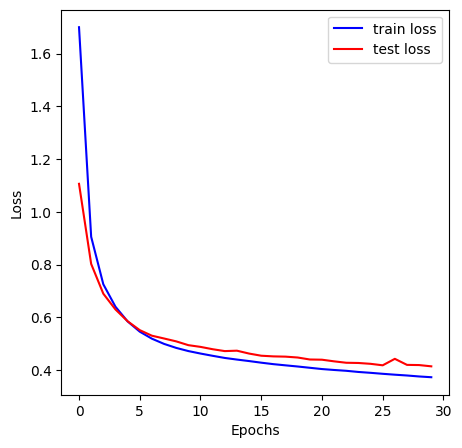

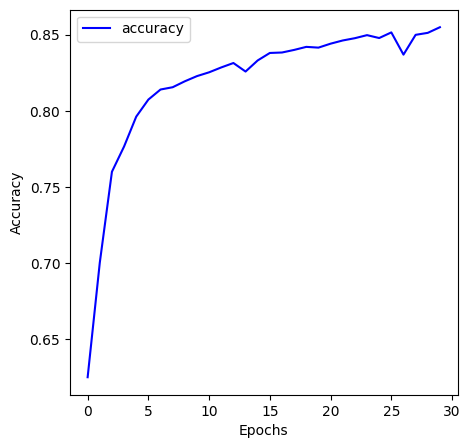

In [18]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn1-opt2")
plot_accuracy(accuracy, "nn1-opt2")

In [19]:
model1_o3 = NeuralNetwork1().to(device)
optimizer3 = torch.optim.SGD(model1_o3.parameters(), lr=0.005)
results = train_model(model1_o3, loss_fn, optimizer3, 30)

100%|██████████| 469/469 [00:08<00:00, 52.77it/s]


Epoch: 01 | Time: 0m 10s | Train Loss: 2.079 | Test Loss: 1.734 | Accuracy: 54.9%


100%|██████████| 469/469 [00:08<00:00, 53.17it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 1.357 | Test Loss: 1.099 | Accuracy: 64.5%


100%|██████████| 469/469 [00:08<00:00, 53.23it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 0.961 | Test Loss: 0.880 | Accuracy: 68.2%


100%|██████████| 469/469 [00:08<00:00, 53.20it/s]


Epoch: 04 | Time: 0m 10s | Train Loss: 0.813 | Test Loss: 0.783 | Accuracy: 71.4%


100%|██████████| 469/469 [00:08<00:00, 53.40it/s]


Epoch: 05 | Time: 0m 10s | Train Loss: 0.737 | Test Loss: 0.724 | Accuracy: 74.0%


100%|██████████| 469/469 [00:08<00:00, 52.74it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 0.686 | Test Loss: 0.680 | Accuracy: 76.0%


100%|██████████| 469/469 [00:08<00:00, 53.39it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 0.646 | Test Loss: 0.649 | Accuracy: 77.2%


100%|██████████| 469/469 [00:08<00:00, 53.42it/s]


Epoch: 08 | Time: 0m 10s | Train Loss: 0.614 | Test Loss: 0.619 | Accuracy: 78.4%


100%|██████████| 469/469 [00:08<00:00, 53.24it/s]


Epoch: 09 | Time: 0m 10s | Train Loss: 0.588 | Test Loss: 0.594 | Accuracy: 79.3%


100%|██████████| 469/469 [00:08<00:00, 53.23it/s]


Epoch: 10 | Time: 0m 10s | Train Loss: 0.566 | Test Loss: 0.577 | Accuracy: 79.6%


100%|██████████| 469/469 [00:08<00:00, 53.13it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 0.548 | Test Loss: 0.563 | Accuracy: 80.3%


100%|██████████| 469/469 [00:08<00:00, 53.33it/s]


Epoch: 12 | Time: 0m 10s | Train Loss: 0.533 | Test Loss: 0.548 | Accuracy: 80.9%


100%|██████████| 469/469 [00:08<00:00, 53.42it/s]


Epoch: 13 | Time: 0m 10s | Train Loss: 0.521 | Test Loss: 0.537 | Accuracy: 81.1%


100%|██████████| 469/469 [00:08<00:00, 53.40it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 0.510 | Test Loss: 0.527 | Accuracy: 81.3%


100%|██████████| 469/469 [00:08<00:00, 53.34it/s]


Epoch: 15 | Time: 0m 10s | Train Loss: 0.501 | Test Loss: 0.522 | Accuracy: 81.6%


100%|██████████| 469/469 [00:08<00:00, 53.48it/s]


Epoch: 16 | Time: 0m 10s | Train Loss: 0.492 | Test Loss: 0.512 | Accuracy: 82.0%


100%|██████████| 469/469 [00:08<00:00, 53.40it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 0.485 | Test Loss: 0.508 | Accuracy: 82.0%


100%|██████████| 469/469 [00:08<00:00, 53.56it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 0.479 | Test Loss: 0.506 | Accuracy: 81.5%


100%|██████████| 469/469 [00:08<00:00, 53.39it/s]


Epoch: 19 | Time: 0m 10s | Train Loss: 0.472 | Test Loss: 0.497 | Accuracy: 82.2%


100%|██████████| 469/469 [00:08<00:00, 53.56it/s]


Epoch: 20 | Time: 0m 10s | Train Loss: 0.467 | Test Loss: 0.491 | Accuracy: 82.5%


100%|██████████| 469/469 [00:08<00:00, 53.19it/s]


Epoch: 21 | Time: 0m 10s | Train Loss: 0.462 | Test Loss: 0.489 | Accuracy: 82.7%


100%|██████████| 469/469 [00:08<00:00, 52.91it/s]


Epoch: 22 | Time: 0m 10s | Train Loss: 0.457 | Test Loss: 0.491 | Accuracy: 82.5%


100%|██████████| 469/469 [00:08<00:00, 53.40it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 0.453 | Test Loss: 0.483 | Accuracy: 82.8%


100%|██████████| 469/469 [00:08<00:00, 53.46it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 0.449 | Test Loss: 0.487 | Accuracy: 82.7%


100%|██████████| 469/469 [00:08<00:00, 53.33it/s]


Epoch: 25 | Time: 0m 10s | Train Loss: 0.445 | Test Loss: 0.479 | Accuracy: 82.7%


100%|██████████| 469/469 [00:08<00:00, 53.37it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 0.441 | Test Loss: 0.470 | Accuracy: 83.3%


100%|██████████| 469/469 [00:08<00:00, 53.42it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.438 | Test Loss: 0.467 | Accuracy: 83.5%


100%|██████████| 469/469 [00:08<00:00, 53.18it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 0.435 | Test Loss: 0.463 | Accuracy: 83.5%


100%|██████████| 469/469 [00:08<00:00, 53.49it/s]


Epoch: 29 | Time: 0m 10s | Train Loss: 0.431 | Test Loss: 0.465 | Accuracy: 83.6%


100%|██████████| 469/469 [00:08<00:00, 52.67it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 0.428 | Test Loss: 0.458 | Accuracy: 83.7%


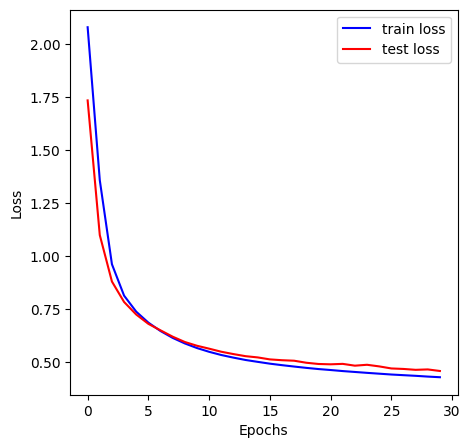

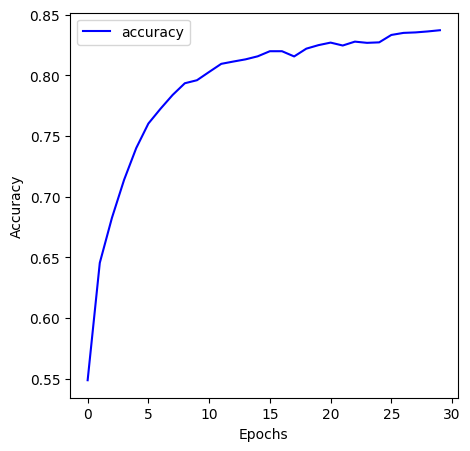

In [20]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn1-opt3")
plot_accuracy(accuracy, "nn1-opt3")

In [21]:
model1_o4 = NeuralNetwork1().to(device)
optimizer4 = torch.optim.SGD(model1_o4.parameters(), lr=1e-3, momentum=0.9)
results = train_model(model1_o4, loss_fn, optimizer4, 30)

100%|██████████| 469/469 [00:10<00:00, 46.86it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 1.723 | Test Loss: 1.089 | Accuracy: 64.5%


100%|██████████| 469/469 [00:09<00:00, 48.59it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 0.886 | Test Loss: 0.786 | Accuracy: 71.9%


100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 0.713 | Test Loss: 0.679 | Accuracy: 75.8%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 04 | Time: 0m 10s | Train Loss: 0.631 | Test Loss: 0.616 | Accuracy: 78.3%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 0.578 | Test Loss: 0.574 | Accuracy: 79.8%


100%|██████████| 469/469 [00:10<00:00, 46.20it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 0.542 | Test Loss: 0.549 | Accuracy: 80.8%


100%|██████████| 469/469 [00:09<00:00, 48.11it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 0.516 | Test Loss: 0.526 | Accuracy: 81.7%


100%|██████████| 469/469 [00:09<00:00, 48.39it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 0.498 | Test Loss: 0.513 | Accuracy: 81.9%


100%|██████████| 469/469 [00:09<00:00, 48.33it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 0.483 | Test Loss: 0.504 | Accuracy: 81.9%


100%|██████████| 469/469 [00:09<00:00, 48.72it/s]


Epoch: 10 | Time: 0m 10s | Train Loss: 0.470 | Test Loss: 0.492 | Accuracy: 82.5%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 0.461 | Test Loss: 0.483 | Accuracy: 82.9%


100%|██████████| 469/469 [00:09<00:00, 48.42it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 0.452 | Test Loss: 0.472 | Accuracy: 83.2%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 0.444 | Test Loss: 0.472 | Accuracy: 83.3%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 0.439 | Test Loss: 0.463 | Accuracy: 83.4%


100%|██████████| 469/469 [00:09<00:00, 48.64it/s]


Epoch: 15 | Time: 0m 10s | Train Loss: 0.433 | Test Loss: 0.458 | Accuracy: 83.7%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 0.427 | Test Loss: 0.456 | Accuracy: 83.6%


100%|██████████| 469/469 [00:09<00:00, 48.43it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 0.421 | Test Loss: 0.447 | Accuracy: 84.2%


100%|██████████| 469/469 [00:09<00:00, 48.40it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 0.416 | Test Loss: 0.445 | Accuracy: 84.4%


100%|██████████| 469/469 [00:09<00:00, 48.38it/s]


Epoch: 19 | Time: 0m 10s | Train Loss: 0.412 | Test Loss: 0.450 | Accuracy: 84.0%


100%|██████████| 469/469 [00:09<00:00, 48.25it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 0.408 | Test Loss: 0.440 | Accuracy: 84.2%


100%|██████████| 469/469 [00:09<00:00, 48.12it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 0.402 | Test Loss: 0.435 | Accuracy: 84.7%


100%|██████████| 469/469 [00:09<00:00, 47.97it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 0.400 | Test Loss: 0.435 | Accuracy: 84.3%


100%|██████████| 469/469 [00:09<00:00, 48.35it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 0.396 | Test Loss: 0.439 | Accuracy: 84.6%


100%|██████████| 469/469 [00:09<00:00, 48.30it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 0.392 | Test Loss: 0.435 | Accuracy: 84.2%


100%|██████████| 469/469 [00:09<00:00, 48.28it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 0.388 | Test Loss: 0.423 | Accuracy: 84.9%


100%|██████████| 469/469 [00:09<00:00, 48.36it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 0.385 | Test Loss: 0.423 | Accuracy: 84.9%


100%|██████████| 469/469 [00:09<00:00, 48.54it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.382 | Test Loss: 0.417 | Accuracy: 85.3%


100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 0.378 | Test Loss: 0.413 | Accuracy: 85.5%


100%|██████████| 469/469 [00:09<00:00, 48.27it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 0.375 | Test Loss: 0.416 | Accuracy: 85.4%


100%|██████████| 469/469 [00:09<00:00, 48.54it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 0.373 | Test Loss: 0.407 | Accuracy: 85.7%


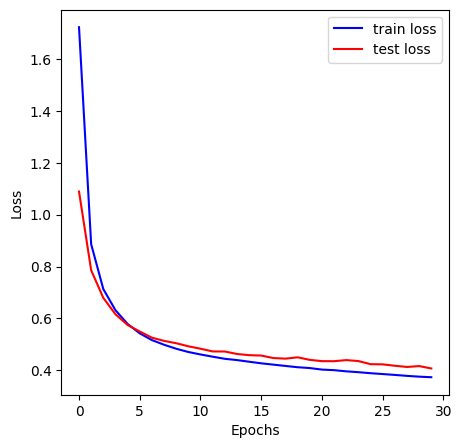

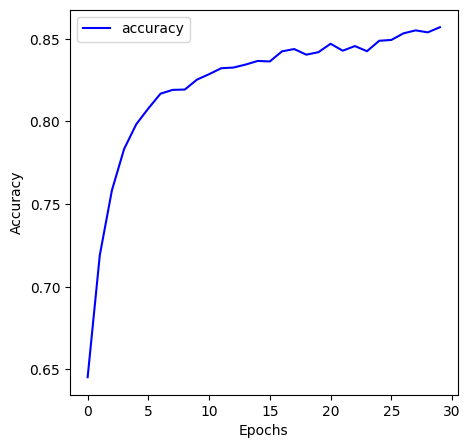

In [22]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn1-opt4")
plot_accuracy(accuracy, "nn1-opt4")

In [23]:
model1_o5 = NeuralNetwork1().to(device)
optimizer5 = torch.optim.SGD(model1_o5.parameters(), lr=0.005, momentum=0.9)
results = train_model(model1_o5, loss_fn, optimizer5, 30)

100%|██████████| 469/469 [00:10<00:00, 46.52it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 1.001 | Test Loss: 0.605 | Accuracy: 78.5%


100%|██████████| 469/469 [00:09<00:00, 48.07it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 0.535 | Test Loss: 0.513 | Accuracy: 81.7%


100%|██████████| 469/469 [00:09<00:00, 49.13it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 0.468 | Test Loss: 0.488 | Accuracy: 82.6%


100%|██████████| 469/469 [00:10<00:00, 46.84it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 0.435 | Test Loss: 0.442 | Accuracy: 84.0%


100%|██████████| 469/469 [00:10<00:00, 46.60it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 0.413 | Test Loss: 0.434 | Accuracy: 84.1%


100%|██████████| 469/469 [00:10<00:00, 46.59it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 0.393 | Test Loss: 0.414 | Accuracy: 85.1%


100%|██████████| 469/469 [00:10<00:00, 46.78it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 0.378 | Test Loss: 0.405 | Accuracy: 85.5%


100%|██████████| 469/469 [00:10<00:00, 46.79it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 0.364 | Test Loss: 0.388 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 46.92it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 0.352 | Test Loss: 0.393 | Accuracy: 86.2%


100%|██████████| 469/469 [00:10<00:00, 46.54it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 0.340 | Test Loss: 0.374 | Accuracy: 86.5%


100%|██████████| 469/469 [00:10<00:00, 46.73it/s]


Epoch: 11 | Time: 0m 11s | Train Loss: 0.332 | Test Loss: 0.391 | Accuracy: 85.9%


100%|██████████| 469/469 [00:10<00:00, 46.61it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 0.323 | Test Loss: 0.372 | Accuracy: 86.5%


100%|██████████| 469/469 [00:10<00:00, 46.13it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 0.314 | Test Loss: 0.373 | Accuracy: 86.4%


100%|██████████| 469/469 [00:10<00:00, 46.77it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 0.304 | Test Loss: 0.353 | Accuracy: 87.4%


100%|██████████| 469/469 [00:10<00:00, 46.74it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 0.300 | Test Loss: 0.350 | Accuracy: 87.4%


100%|██████████| 469/469 [00:10<00:00, 46.60it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 0.292 | Test Loss: 0.346 | Accuracy: 87.6%


100%|██████████| 469/469 [00:10<00:00, 46.89it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 0.288 | Test Loss: 0.360 | Accuracy: 87.1%


100%|██████████| 469/469 [00:09<00:00, 47.03it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 0.280 | Test Loss: 0.334 | Accuracy: 88.1%


100%|██████████| 469/469 [00:10<00:00, 46.43it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 0.274 | Test Loss: 0.340 | Accuracy: 87.9%


100%|██████████| 469/469 [00:10<00:00, 46.88it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 0.270 | Test Loss: 0.335 | Accuracy: 88.0%


100%|██████████| 469/469 [00:09<00:00, 46.92it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 0.263 | Test Loss: 0.341 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 46.72it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 0.258 | Test Loss: 0.353 | Accuracy: 87.5%


100%|██████████| 469/469 [00:10<00:00, 46.73it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 0.253 | Test Loss: 0.361 | Accuracy: 87.1%


100%|██████████| 469/469 [00:10<00:00, 46.87it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 0.249 | Test Loss: 0.325 | Accuracy: 88.1%


100%|██████████| 469/469 [00:10<00:00, 46.74it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 0.243 | Test Loss: 0.323 | Accuracy: 88.5%


100%|██████████| 469/469 [00:10<00:00, 46.81it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 0.239 | Test Loss: 0.331 | Accuracy: 88.1%


100%|██████████| 469/469 [00:10<00:00, 46.87it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 0.234 | Test Loss: 0.339 | Accuracy: 87.5%


100%|██████████| 469/469 [00:10<00:00, 46.81it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 0.231 | Test Loss: 0.332 | Accuracy: 88.4%


100%|██████████| 469/469 [00:10<00:00, 46.63it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 0.224 | Test Loss: 0.321 | Accuracy: 88.3%


100%|██████████| 469/469 [00:10<00:00, 46.70it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 0.221 | Test Loss: 0.338 | Accuracy: 88.0%


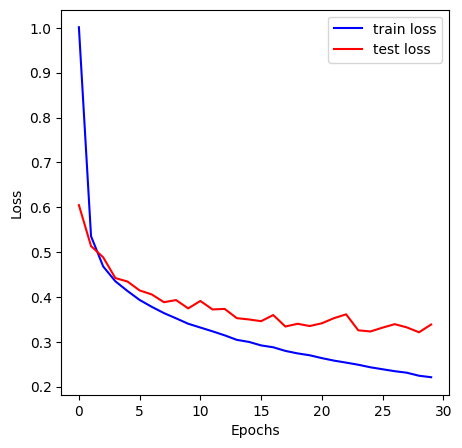

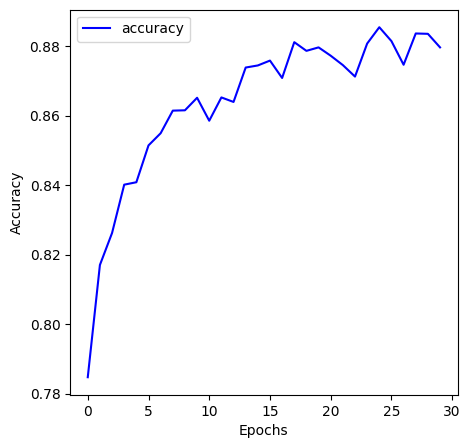

In [24]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn1-opt5")
plot_accuracy(accuracy, "nn1-opt5")

In [25]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [26]:
model2 = NeuralNetwork2().to(device)
print(model2)
count_parameters(model2)
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)
results = train_model(model2, loss_fn, optimizer, 50)

NeuralNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
1,477,066 total parameters.
1,477,066 training parameters.


100%|██████████| 469/469 [00:09<00:00, 47.58it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 2.305 | Test Loss: 2.303 | Accuracy: 10.0%


100%|██████████| 469/469 [00:09<00:00, 50.68it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 2.302 | Test Loss: 2.301 | Accuracy: 10.0%


100%|██████████| 469/469 [00:09<00:00, 50.33it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 2.300 | Test Loss: 2.299 | Accuracy: 10.0%


100%|██████████| 469/469 [00:09<00:00, 48.39it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 2.298 | Test Loss: 2.297 | Accuracy: 10.0%


100%|██████████| 469/469 [00:09<00:00, 49.96it/s]


Epoch: 05 | Time: 0m 10s | Train Loss: 2.295 | Test Loss: 2.294 | Accuracy: 10.1%


100%|██████████| 469/469 [00:09<00:00, 50.95it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 2.292 | Test Loss: 2.291 | Accuracy: 10.3%


100%|██████████| 469/469 [00:09<00:00, 51.11it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 2.289 | Test Loss: 2.288 | Accuracy: 11.2%


100%|██████████| 469/469 [00:09<00:00, 48.98it/s]


Epoch: 08 | Time: 0m 10s | Train Loss: 2.286 | Test Loss: 2.284 | Accuracy: 13.3%


100%|██████████| 469/469 [00:09<00:00, 47.79it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 2.282 | Test Loss: 2.280 | Accuracy: 17.5%


100%|██████████| 469/469 [00:10<00:00, 46.52it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 2.277 | Test Loss: 2.274 | Accuracy: 22.2%


100%|██████████| 469/469 [00:09<00:00, 49.56it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 2.271 | Test Loss: 2.267 | Accuracy: 25.7%


100%|██████████| 469/469 [00:09<00:00, 47.73it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 2.263 | Test Loss: 2.259 | Accuracy: 27.5%


100%|██████████| 469/469 [00:09<00:00, 49.73it/s]


Epoch: 13 | Time: 0m 10s | Train Loss: 2.253 | Test Loss: 2.248 | Accuracy: 28.3%


100%|██████████| 469/469 [00:09<00:00, 49.71it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 2.240 | Test Loss: 2.233 | Accuracy: 28.4%


100%|██████████| 469/469 [00:10<00:00, 46.09it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 2.223 | Test Loss: 2.212 | Accuracy: 28.5%


100%|██████████| 469/469 [00:10<00:00, 46.33it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 2.198 | Test Loss: 2.183 | Accuracy: 28.0%


100%|██████████| 469/469 [00:10<00:00, 44.09it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 2.161 | Test Loss: 2.138 | Accuracy: 27.5%


100%|██████████| 469/469 [00:10<00:00, 44.62it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 2.106 | Test Loss: 2.070 | Accuracy: 27.5%


100%|██████████| 469/469 [00:10<00:00, 44.41it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 2.019 | Test Loss: 1.966 | Accuracy: 28.4%


100%|██████████| 469/469 [00:10<00:00, 44.52it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 1.895 | Test Loss: 1.824 | Accuracy: 30.2%


100%|██████████| 469/469 [00:10<00:00, 46.04it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 1.742 | Test Loss: 1.667 | Accuracy: 42.1%


100%|██████████| 469/469 [00:10<00:00, 44.50it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 1.590 | Test Loss: 1.526 | Accuracy: 44.0%


100%|██████████| 469/469 [00:10<00:00, 44.04it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.460 | Test Loss: 1.410 | Accuracy: 44.5%


100%|██████████| 469/469 [00:10<00:00, 44.63it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 1.354 | Test Loss: 1.316 | Accuracy: 47.5%


100%|██████████| 469/469 [00:10<00:00, 44.24it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.268 | Test Loss: 1.240 | Accuracy: 52.4%


100%|██████████| 469/469 [00:10<00:00, 45.98it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 1.199 | Test Loss: 1.178 | Accuracy: 56.4%


100%|██████████| 469/469 [00:09<00:00, 48.03it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 1.141 | Test Loss: 1.125 | Accuracy: 57.8%


100%|██████████| 469/469 [00:10<00:00, 44.25it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 1.091 | Test Loss: 1.079 | Accuracy: 60.0%


100%|██████████| 469/469 [00:10<00:00, 45.80it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 1.046 | Test Loss: 1.037 | Accuracy: 60.7%


100%|██████████| 469/469 [00:10<00:00, 46.09it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 1.006 | Test Loss: 1.000 | Accuracy: 61.9%


100%|██████████| 469/469 [00:10<00:00, 44.51it/s]


Epoch: 31 | Time: 0m 11s | Train Loss: 0.971 | Test Loss: 0.968 | Accuracy: 63.5%


100%|██████████| 469/469 [00:09<00:00, 47.96it/s]


Epoch: 32 | Time: 0m 11s | Train Loss: 0.941 | Test Loss: 0.940 | Accuracy: 63.8%


100%|██████████| 469/469 [00:09<00:00, 50.18it/s]


Epoch: 33 | Time: 0m 10s | Train Loss: 0.916 | Test Loss: 0.917 | Accuracy: 65.0%


100%|██████████| 469/469 [00:09<00:00, 47.80it/s]


Epoch: 34 | Time: 0m 11s | Train Loss: 0.895 | Test Loss: 0.901 | Accuracy: 65.2%


100%|██████████| 469/469 [00:09<00:00, 47.98it/s]


Epoch: 35 | Time: 0m 11s | Train Loss: 0.877 | Test Loss: 0.883 | Accuracy: 66.1%


100%|██████████| 469/469 [00:10<00:00, 45.86it/s]


Epoch: 36 | Time: 0m 11s | Train Loss: 0.862 | Test Loss: 0.869 | Accuracy: 66.2%


100%|██████████| 469/469 [00:10<00:00, 45.96it/s]


Epoch: 37 | Time: 0m 11s | Train Loss: 0.850 | Test Loss: 0.858 | Accuracy: 67.0%


100%|██████████| 469/469 [00:09<00:00, 47.97it/s]


Epoch: 38 | Time: 0m 11s | Train Loss: 0.838 | Test Loss: 0.846 | Accuracy: 67.7%


100%|██████████| 469/469 [00:09<00:00, 48.13it/s]


Epoch: 39 | Time: 0m 11s | Train Loss: 0.828 | Test Loss: 0.838 | Accuracy: 67.9%


100%|██████████| 469/469 [00:09<00:00, 48.00it/s]


Epoch: 40 | Time: 0m 11s | Train Loss: 0.818 | Test Loss: 0.828 | Accuracy: 68.7%


100%|██████████| 469/469 [00:09<00:00, 49.44it/s]


Epoch: 41 | Time: 0m 10s | Train Loss: 0.809 | Test Loss: 0.819 | Accuracy: 69.3%


100%|██████████| 469/469 [00:09<00:00, 47.83it/s]


Epoch: 42 | Time: 0m 11s | Train Loss: 0.801 | Test Loss: 0.812 | Accuracy: 69.5%


100%|██████████| 469/469 [00:09<00:00, 47.77it/s]


Epoch: 43 | Time: 0m 11s | Train Loss: 0.793 | Test Loss: 0.804 | Accuracy: 69.9%


100%|██████████| 469/469 [00:10<00:00, 44.18it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 0.786 | Test Loss: 0.798 | Accuracy: 70.5%


100%|██████████| 469/469 [00:10<00:00, 44.45it/s]


Epoch: 45 | Time: 0m 11s | Train Loss: 0.778 | Test Loss: 0.790 | Accuracy: 71.0%


100%|██████████| 469/469 [00:09<00:00, 47.51it/s]


Epoch: 46 | Time: 0m 11s | Train Loss: 0.771 | Test Loss: 0.783 | Accuracy: 71.4%


100%|██████████| 469/469 [00:09<00:00, 49.44it/s]


Epoch: 47 | Time: 0m 10s | Train Loss: 0.763 | Test Loss: 0.776 | Accuracy: 71.5%


100%|██████████| 469/469 [00:10<00:00, 46.45it/s]


Epoch: 48 | Time: 0m 11s | Train Loss: 0.756 | Test Loss: 0.770 | Accuracy: 72.0%


100%|██████████| 469/469 [00:10<00:00, 46.13it/s]


Epoch: 49 | Time: 0m 11s | Train Loss: 0.749 | Test Loss: 0.763 | Accuracy: 72.2%


100%|██████████| 469/469 [00:10<00:00, 44.13it/s]


Epoch: 50 | Time: 0m 12s | Train Loss: 0.742 | Test Loss: 0.756 | Accuracy: 72.7%


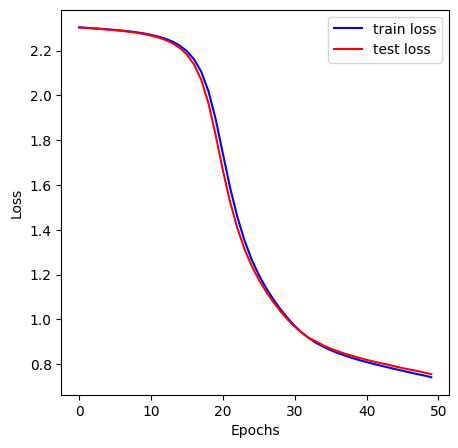

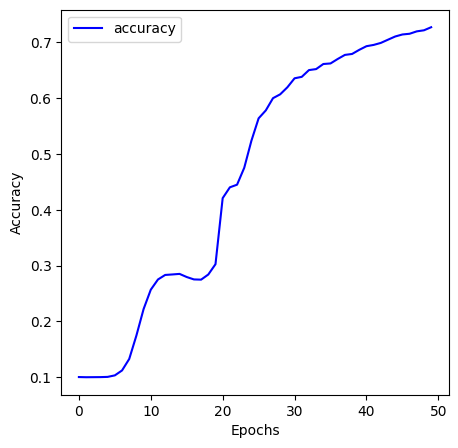

In [27]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn2")
plot_accuracy(accuracy, "nn2")

In [28]:
class NeuralNetwork3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [29]:
model3 = NeuralNetwork3().to(device)
print(model3)
count_parameters(model3)
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-3)
results = train_model(model3, loss_fn, optimizer, 50)

NeuralNetwork3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
1,083,338 total parameters.
1,083,338 training parameters.


100%|██████████| 469/469 [00:10<00:00, 45.97it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 2.298 | Test Loss: 2.291 | Accuracy: 12.3%


100%|██████████| 469/469 [00:09<00:00, 48.22it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 2.283 | Test Loss: 2.275 | Accuracy: 11.7%


100%|██████████| 469/469 [00:09<00:00, 48.43it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 2.266 | Test Loss: 2.257 | Accuracy: 14.7%


100%|██████████| 469/469 [00:09<00:00, 48.42it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 2.245 | Test Loss: 2.232 | Accuracy: 20.8%


100%|██████████| 469/469 [00:09<00:00, 48.38it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 2.216 | Test Loss: 2.199 | Accuracy: 33.2%


100%|██████████| 469/469 [00:09<00:00, 48.68it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 2.178 | Test Loss: 2.154 | Accuracy: 40.1%


100%|██████████| 469/469 [00:09<00:00, 48.78it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 2.123 | Test Loss: 2.090 | Accuracy: 43.9%


100%|██████████| 469/469 [00:09<00:00, 48.22it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 2.047 | Test Loss: 1.999 | Accuracy: 44.7%


100%|██████████| 469/469 [00:09<00:00, 48.55it/s]


Epoch: 09 | Time: 0m 10s | Train Loss: 1.939 | Test Loss: 1.873 | Accuracy: 46.9%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 1.792 | Test Loss: 1.709 | Accuracy: 51.4%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 1.617 | Test Loss: 1.531 | Accuracy: 55.1%


100%|██████████| 469/469 [00:09<00:00, 48.18it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 1.448 | Test Loss: 1.378 | Accuracy: 57.8%


100%|██████████| 469/469 [00:09<00:00, 48.68it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 1.312 | Test Loss: 1.260 | Accuracy: 59.0%


100%|██████████| 469/469 [00:09<00:00, 47.56it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 1.208 | Test Loss: 1.172 | Accuracy: 59.6%


100%|██████████| 469/469 [00:10<00:00, 46.64it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 1.129 | Test Loss: 1.103 | Accuracy: 61.2%


100%|██████████| 469/469 [00:09<00:00, 47.10it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 1.067 | Test Loss: 1.049 | Accuracy: 62.5%


100%|██████████| 469/469 [00:09<00:00, 47.00it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 1.017 | Test Loss: 1.005 | Accuracy: 62.8%


100%|██████████| 469/469 [00:10<00:00, 46.80it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 0.975 | Test Loss: 0.967 | Accuracy: 64.6%


100%|██████████| 469/469 [00:09<00:00, 47.07it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 0.941 | Test Loss: 0.935 | Accuracy: 65.5%


100%|██████████| 469/469 [00:10<00:00, 46.84it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 0.910 | Test Loss: 0.909 | Accuracy: 65.8%


100%|██████████| 469/469 [00:10<00:00, 46.84it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 0.884 | Test Loss: 0.884 | Accuracy: 67.3%


100%|██████████| 469/469 [00:10<00:00, 46.78it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 0.861 | Test Loss: 0.863 | Accuracy: 67.6%


100%|██████████| 469/469 [00:10<00:00, 46.60it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 0.841 | Test Loss: 0.844 | Accuracy: 68.4%


100%|██████████| 469/469 [00:09<00:00, 47.78it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 0.822 | Test Loss: 0.826 | Accuracy: 69.2%


100%|██████████| 469/469 [00:09<00:00, 47.64it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 0.805 | Test Loss: 0.810 | Accuracy: 69.9%


100%|██████████| 469/469 [00:09<00:00, 47.47it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 0.790 | Test Loss: 0.797 | Accuracy: 70.7%


100%|██████████| 469/469 [00:09<00:00, 49.00it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.776 | Test Loss: 0.783 | Accuracy: 70.6%


100%|██████████| 469/469 [00:09<00:00, 46.95it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 0.763 | Test Loss: 0.771 | Accuracy: 71.4%


100%|██████████| 469/469 [00:09<00:00, 47.06it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 0.751 | Test Loss: 0.759 | Accuracy: 71.8%


100%|██████████| 469/469 [00:10<00:00, 46.87it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 0.739 | Test Loss: 0.749 | Accuracy: 71.9%


100%|██████████| 469/469 [00:08<00:00, 54.72it/s]


Epoch: 31 | Time: 0m 9s | Train Loss: 0.729 | Test Loss: 0.737 | Accuracy: 72.9%


100%|██████████| 469/469 [00:09<00:00, 50.29it/s]


Epoch: 32 | Time: 0m 10s | Train Loss: 0.718 | Test Loss: 0.730 | Accuracy: 72.9%


100%|██████████| 469/469 [00:08<00:00, 57.31it/s]


Epoch: 33 | Time: 0m 9s | Train Loss: 0.709 | Test Loss: 0.719 | Accuracy: 73.5%


100%|██████████| 469/469 [00:09<00:00, 50.30it/s]


Epoch: 34 | Time: 0m 10s | Train Loss: 0.700 | Test Loss: 0.710 | Accuracy: 74.4%


100%|██████████| 469/469 [00:09<00:00, 49.75it/s]


Epoch: 35 | Time: 0m 10s | Train Loss: 0.691 | Test Loss: 0.702 | Accuracy: 74.5%


100%|██████████| 469/469 [00:09<00:00, 50.25it/s]


Epoch: 36 | Time: 0m 10s | Train Loss: 0.683 | Test Loss: 0.694 | Accuracy: 74.8%


100%|██████████| 469/469 [00:08<00:00, 56.01it/s]


Epoch: 37 | Time: 0m 9s | Train Loss: 0.675 | Test Loss: 0.687 | Accuracy: 75.1%


100%|██████████| 469/469 [00:09<00:00, 50.35it/s]


Epoch: 38 | Time: 0m 10s | Train Loss: 0.668 | Test Loss: 0.679 | Accuracy: 75.5%


100%|██████████| 469/469 [00:09<00:00, 50.03it/s]


Epoch: 39 | Time: 0m 10s | Train Loss: 0.660 | Test Loss: 0.672 | Accuracy: 75.9%


100%|██████████| 469/469 [00:09<00:00, 49.66it/s]


Epoch: 40 | Time: 0m 10s | Train Loss: 0.653 | Test Loss: 0.666 | Accuracy: 76.0%


100%|██████████| 469/469 [00:09<00:00, 50.04it/s]


Epoch: 41 | Time: 0m 10s | Train Loss: 0.647 | Test Loss: 0.659 | Accuracy: 76.3%


100%|██████████| 469/469 [00:09<00:00, 50.04it/s]


Epoch: 42 | Time: 0m 10s | Train Loss: 0.640 | Test Loss: 0.653 | Accuracy: 76.5%


100%|██████████| 469/469 [00:09<00:00, 49.96it/s]


Epoch: 43 | Time: 0m 10s | Train Loss: 0.634 | Test Loss: 0.647 | Accuracy: 76.7%


100%|██████████| 469/469 [00:09<00:00, 50.12it/s]


Epoch: 44 | Time: 0m 10s | Train Loss: 0.628 | Test Loss: 0.642 | Accuracy: 76.9%


100%|██████████| 469/469 [00:09<00:00, 50.31it/s]


Epoch: 45 | Time: 0m 10s | Train Loss: 0.622 | Test Loss: 0.635 | Accuracy: 76.8%


100%|██████████| 469/469 [00:09<00:00, 50.25it/s]


Epoch: 46 | Time: 0m 10s | Train Loss: 0.617 | Test Loss: 0.631 | Accuracy: 77.2%


100%|██████████| 469/469 [00:09<00:00, 50.34it/s]


Epoch: 47 | Time: 0m 10s | Train Loss: 0.612 | Test Loss: 0.626 | Accuracy: 77.4%


100%|██████████| 469/469 [00:09<00:00, 50.40it/s]


Epoch: 48 | Time: 0m 10s | Train Loss: 0.607 | Test Loss: 0.621 | Accuracy: 77.5%


100%|██████████| 469/469 [00:09<00:00, 50.33it/s]


Epoch: 49 | Time: 0m 10s | Train Loss: 0.602 | Test Loss: 0.617 | Accuracy: 77.8%


100%|██████████| 469/469 [00:09<00:00, 50.27it/s]


Epoch: 50 | Time: 0m 10s | Train Loss: 0.598 | Test Loss: 0.613 | Accuracy: 78.1%


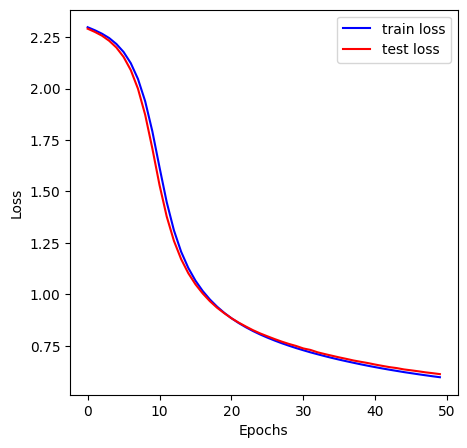

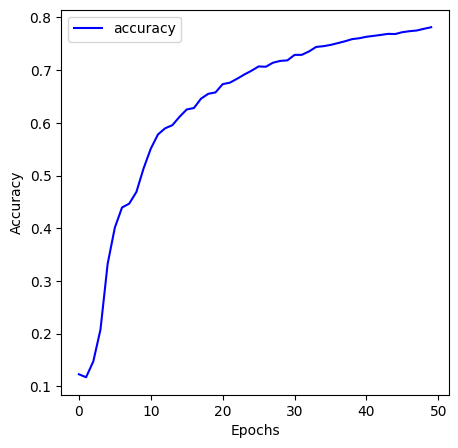

In [30]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn3")
plot_accuracy(accuracy, "nn3")

In [31]:
class NeuralNetwork4(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [32]:
model4 = NeuralNetwork4().to(device)
print(model4)
count_parameters(model4)
optimizer = torch.optim.SGD(model4.parameters(), lr=1e-3)
results = train_model(model4, loss_fn, optimizer, 40)

NeuralNetwork4(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
485,386 total parameters.
485,386 training parameters.


100%|██████████| 469/469 [00:08<00:00, 54.62it/s]


Epoch: 01 | Time: 0m 9s | Train Loss: 2.298 | Test Loss: 2.293 | Accuracy: 11.6%


100%|██████████| 469/469 [00:08<00:00, 55.67it/s]


Epoch: 02 | Time: 0m 9s | Train Loss: 2.288 | Test Loss: 2.282 | Accuracy: 16.1%


100%|██████████| 469/469 [00:08<00:00, 55.55it/s]


Epoch: 03 | Time: 0m 9s | Train Loss: 2.276 | Test Loss: 2.268 | Accuracy: 25.9%


100%|██████████| 469/469 [00:08<00:00, 55.74it/s]


Epoch: 04 | Time: 0m 9s | Train Loss: 2.259 | Test Loss: 2.249 | Accuracy: 36.2%


100%|██████████| 469/469 [00:08<00:00, 55.73it/s]


Epoch: 05 | Time: 0m 9s | Train Loss: 2.237 | Test Loss: 2.223 | Accuracy: 43.7%


100%|██████████| 469/469 [00:08<00:00, 55.72it/s]


Epoch: 06 | Time: 0m 9s | Train Loss: 2.204 | Test Loss: 2.183 | Accuracy: 48.0%


100%|██████████| 469/469 [00:08<00:00, 55.76it/s]


Epoch: 07 | Time: 0m 9s | Train Loss: 2.154 | Test Loss: 2.122 | Accuracy: 45.5%


100%|██████████| 469/469 [00:08<00:00, 55.76it/s]


Epoch: 08 | Time: 0m 9s | Train Loss: 2.079 | Test Loss: 2.030 | Accuracy: 43.5%


100%|██████████| 469/469 [00:08<00:00, 55.68it/s]


Epoch: 09 | Time: 0m 9s | Train Loss: 1.969 | Test Loss: 1.904 | Accuracy: 43.7%


100%|██████████| 469/469 [00:08<00:00, 55.82it/s]


Epoch: 10 | Time: 0m 9s | Train Loss: 1.830 | Test Loss: 1.760 | Accuracy: 45.6%


100%|██████████| 469/469 [00:08<00:00, 55.64it/s]


Epoch: 11 | Time: 0m 9s | Train Loss: 1.687 | Test Loss: 1.619 | Accuracy: 47.0%


100%|██████████| 469/469 [00:08<00:00, 55.80it/s]


Epoch: 12 | Time: 0m 9s | Train Loss: 1.552 | Test Loss: 1.493 | Accuracy: 53.6%


100%|██████████| 469/469 [00:08<00:00, 55.60it/s]


Epoch: 13 | Time: 0m 9s | Train Loss: 1.433 | Test Loss: 1.385 | Accuracy: 55.7%


100%|██████████| 469/469 [00:08<00:00, 55.61it/s]


Epoch: 14 | Time: 0m 9s | Train Loss: 1.335 | Test Loss: 1.296 | Accuracy: 57.0%


100%|██████████| 469/469 [00:08<00:00, 55.77it/s]


Epoch: 15 | Time: 0m 9s | Train Loss: 1.253 | Test Loss: 1.223 | Accuracy: 58.3%


100%|██████████| 469/469 [00:08<00:00, 55.66it/s]


Epoch: 16 | Time: 0m 9s | Train Loss: 1.186 | Test Loss: 1.163 | Accuracy: 58.8%


100%|██████████| 469/469 [00:08<00:00, 55.77it/s]


Epoch: 17 | Time: 0m 9s | Train Loss: 1.130 | Test Loss: 1.112 | Accuracy: 59.0%


100%|██████████| 469/469 [00:08<00:00, 55.76it/s]


Epoch: 18 | Time: 0m 9s | Train Loss: 1.083 | Test Loss: 1.068 | Accuracy: 60.2%


100%|██████████| 469/469 [00:08<00:00, 55.61it/s]


Epoch: 19 | Time: 0m 9s | Train Loss: 1.041 | Test Loss: 1.030 | Accuracy: 61.2%


100%|██████████| 469/469 [00:08<00:00, 55.55it/s]


Epoch: 20 | Time: 0m 9s | Train Loss: 1.005 | Test Loss: 0.996 | Accuracy: 61.9%


100%|██████████| 469/469 [00:08<00:00, 55.71it/s]


Epoch: 21 | Time: 0m 9s | Train Loss: 0.973 | Test Loss: 0.966 | Accuracy: 62.8%


100%|██████████| 469/469 [00:08<00:00, 55.95it/s]


Epoch: 22 | Time: 0m 9s | Train Loss: 0.943 | Test Loss: 0.939 | Accuracy: 63.7%


100%|██████████| 469/469 [00:08<00:00, 55.70it/s]


Epoch: 23 | Time: 0m 9s | Train Loss: 0.917 | Test Loss: 0.915 | Accuracy: 64.8%


100%|██████████| 469/469 [00:08<00:00, 55.76it/s]


Epoch: 24 | Time: 0m 9s | Train Loss: 0.893 | Test Loss: 0.892 | Accuracy: 64.9%


100%|██████████| 469/469 [00:08<00:00, 55.94it/s]


Epoch: 25 | Time: 0m 9s | Train Loss: 0.872 | Test Loss: 0.872 | Accuracy: 65.2%


100%|██████████| 469/469 [00:08<00:00, 53.03it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 0.852 | Test Loss: 0.855 | Accuracy: 66.1%


100%|██████████| 469/469 [00:08<00:00, 54.29it/s]


Epoch: 27 | Time: 0m 9s | Train Loss: 0.835 | Test Loss: 0.839 | Accuracy: 65.8%


100%|██████████| 469/469 [00:08<00:00, 54.72it/s]


Epoch: 28 | Time: 0m 9s | Train Loss: 0.819 | Test Loss: 0.824 | Accuracy: 66.7%


100%|██████████| 469/469 [00:08<00:00, 54.99it/s]


Epoch: 29 | Time: 0m 9s | Train Loss: 0.804 | Test Loss: 0.810 | Accuracy: 67.4%


100%|██████████| 469/469 [00:08<00:00, 54.90it/s]


Epoch: 30 | Time: 0m 9s | Train Loss: 0.792 | Test Loss: 0.798 | Accuracy: 68.2%


100%|██████████| 469/469 [00:08<00:00, 58.00it/s]


Epoch: 31 | Time: 0m 9s | Train Loss: 0.780 | Test Loss: 0.788 | Accuracy: 68.5%


100%|██████████| 469/469 [00:08<00:00, 54.93it/s]


Epoch: 32 | Time: 0m 9s | Train Loss: 0.769 | Test Loss: 0.779 | Accuracy: 69.2%


100%|██████████| 469/469 [00:08<00:00, 54.64it/s]


Epoch: 33 | Time: 0m 9s | Train Loss: 0.760 | Test Loss: 0.769 | Accuracy: 69.2%


100%|██████████| 469/469 [00:07<00:00, 58.76it/s]


Epoch: 34 | Time: 0m 9s | Train Loss: 0.751 | Test Loss: 0.762 | Accuracy: 69.6%


100%|██████████| 469/469 [00:08<00:00, 54.77it/s]


Epoch: 35 | Time: 0m 9s | Train Loss: 0.743 | Test Loss: 0.754 | Accuracy: 69.9%


100%|██████████| 469/469 [00:08<00:00, 54.75it/s]


Epoch: 36 | Time: 0m 9s | Train Loss: 0.735 | Test Loss: 0.747 | Accuracy: 70.5%


100%|██████████| 469/469 [00:08<00:00, 54.88it/s]


Epoch: 37 | Time: 0m 9s | Train Loss: 0.728 | Test Loss: 0.740 | Accuracy: 70.7%


100%|██████████| 469/469 [00:08<00:00, 54.44it/s]


Epoch: 38 | Time: 0m 9s | Train Loss: 0.721 | Test Loss: 0.735 | Accuracy: 71.3%


100%|██████████| 469/469 [00:08<00:00, 55.01it/s]


Epoch: 39 | Time: 0m 9s | Train Loss: 0.715 | Test Loss: 0.728 | Accuracy: 71.5%


100%|██████████| 469/469 [00:08<00:00, 55.20it/s]


Epoch: 40 | Time: 0m 9s | Train Loss: 0.709 | Test Loss: 0.722 | Accuracy: 72.0%


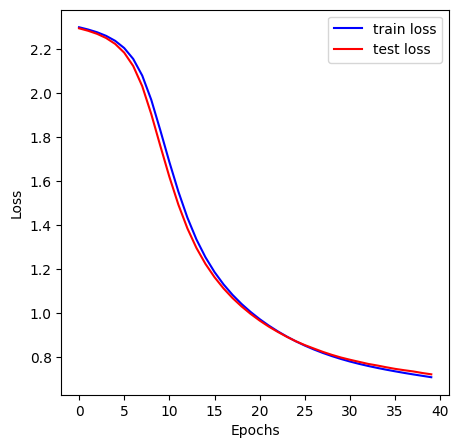

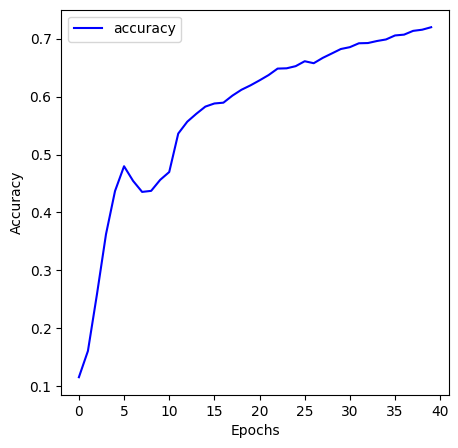

In [33]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn4")
plot_accuracy(accuracy, "nn4")

In [34]:
model2_o1 = NeuralNetwork2().to(device)
print(model2_o1)
count_parameters(model2_o1)
optimizer = torch.optim.SGD(model2_o1.parameters(), lr=1e-3, momentum=0.9)
results = train_model(model2_o1, loss_fn, optimizer, 50)

NeuralNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
1,477,066 total parameters.
1,477,066 training parameters.


100%|██████████| 469/469 [00:10<00:00, 44.62it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 2.288 | Test Loss: 2.261 | Accuracy: 29.4%


100%|██████████| 469/469 [00:10<00:00, 45.46it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 2.080 | Test Loss: 1.624 | Accuracy: 43.6%


100%|██████████| 469/469 [00:10<00:00, 45.46it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 1.187 | Test Loss: 0.985 | Accuracy: 62.0%


100%|██████████| 469/469 [00:10<00:00, 45.43it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 0.877 | Test Loss: 0.819 | Accuracy: 69.0%


100%|██████████| 469/469 [00:10<00:00, 45.57it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 0.754 | Test Loss: 0.734 | Accuracy: 73.5%


100%|██████████| 469/469 [00:10<00:00, 45.64it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 0.675 | Test Loss: 0.671 | Accuracy: 76.0%


100%|██████████| 469/469 [00:10<00:00, 45.54it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 0.623 | Test Loss: 0.630 | Accuracy: 77.2%


100%|██████████| 469/469 [00:10<00:00, 44.80it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 0.587 | Test Loss: 0.593 | Accuracy: 78.7%


100%|██████████| 469/469 [00:10<00:00, 42.95it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 0.557 | Test Loss: 0.578 | Accuracy: 79.7%


100%|██████████| 469/469 [00:10<00:00, 45.62it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 0.536 | Test Loss: 0.559 | Accuracy: 80.2%


100%|██████████| 469/469 [00:10<00:00, 45.44it/s]


Epoch: 11 | Time: 0m 11s | Train Loss: 0.518 | Test Loss: 0.537 | Accuracy: 80.9%


100%|██████████| 469/469 [00:10<00:00, 45.42it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 0.502 | Test Loss: 0.531 | Accuracy: 81.2%


100%|██████████| 469/469 [00:10<00:00, 45.53it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 0.486 | Test Loss: 0.521 | Accuracy: 81.2%


100%|██████████| 469/469 [00:10<00:00, 45.47it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 0.475 | Test Loss: 0.505 | Accuracy: 82.2%


100%|██████████| 469/469 [00:10<00:00, 45.66it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 0.463 | Test Loss: 0.496 | Accuracy: 82.0%


100%|██████████| 469/469 [00:09<00:00, 49.30it/s]


Epoch: 16 | Time: 0m 10s | Train Loss: 0.450 | Test Loss: 0.480 | Accuracy: 82.7%


100%|██████████| 469/469 [00:09<00:00, 50.04it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 0.441 | Test Loss: 0.471 | Accuracy: 83.5%


100%|██████████| 469/469 [00:09<00:00, 49.90it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 0.430 | Test Loss: 0.455 | Accuracy: 83.9%


100%|██████████| 469/469 [00:09<00:00, 48.74it/s]


Epoch: 19 | Time: 0m 10s | Train Loss: 0.417 | Test Loss: 0.455 | Accuracy: 83.6%


100%|██████████| 469/469 [00:09<00:00, 49.34it/s]


Epoch: 20 | Time: 0m 10s | Train Loss: 0.410 | Test Loss: 0.435 | Accuracy: 84.5%


100%|██████████| 469/469 [00:09<00:00, 48.94it/s]


Epoch: 21 | Time: 0m 10s | Train Loss: 0.401 | Test Loss: 0.448 | Accuracy: 83.9%


100%|██████████| 469/469 [00:09<00:00, 49.03it/s]


Epoch: 22 | Time: 0m 10s | Train Loss: 0.391 | Test Loss: 0.428 | Accuracy: 84.7%


100%|██████████| 469/469 [00:09<00:00, 49.19it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 0.383 | Test Loss: 0.417 | Accuracy: 85.2%


100%|██████████| 469/469 [00:09<00:00, 49.25it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 0.377 | Test Loss: 0.409 | Accuracy: 85.1%


100%|██████████| 469/469 [00:09<00:00, 49.13it/s]


Epoch: 25 | Time: 0m 10s | Train Loss: 0.370 | Test Loss: 0.405 | Accuracy: 85.6%


100%|██████████| 469/469 [00:09<00:00, 48.79it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 0.363 | Test Loss: 0.409 | Accuracy: 85.2%


100%|██████████| 469/469 [00:09<00:00, 49.28it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 0.355 | Test Loss: 0.397 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 49.25it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 0.349 | Test Loss: 0.395 | Accuracy: 85.6%


100%|██████████| 469/469 [00:09<00:00, 48.57it/s]


Epoch: 29 | Time: 0m 10s | Train Loss: 0.346 | Test Loss: 0.386 | Accuracy: 86.4%


100%|██████████| 469/469 [00:09<00:00, 49.17it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 0.337 | Test Loss: 0.389 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 48.59it/s]


Epoch: 31 | Time: 0m 10s | Train Loss: 0.333 | Test Loss: 0.385 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 48.58it/s]


Epoch: 32 | Time: 0m 10s | Train Loss: 0.327 | Test Loss: 0.373 | Accuracy: 86.4%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 33 | Time: 0m 10s | Train Loss: 0.321 | Test Loss: 0.374 | Accuracy: 86.5%


100%|██████████| 469/469 [00:09<00:00, 49.18it/s]


Epoch: 34 | Time: 0m 10s | Train Loss: 0.317 | Test Loss: 0.370 | Accuracy: 86.8%


100%|██████████| 469/469 [00:09<00:00, 48.81it/s]


Epoch: 35 | Time: 0m 10s | Train Loss: 0.311 | Test Loss: 0.362 | Accuracy: 86.8%


100%|██████████| 469/469 [00:09<00:00, 48.92it/s]


Epoch: 36 | Time: 0m 10s | Train Loss: 0.307 | Test Loss: 0.397 | Accuracy: 85.9%


100%|██████████| 469/469 [00:09<00:00, 48.81it/s]


Epoch: 37 | Time: 0m 10s | Train Loss: 0.302 | Test Loss: 0.355 | Accuracy: 87.4%


100%|██████████| 469/469 [00:09<00:00, 48.94it/s]


Epoch: 38 | Time: 0m 10s | Train Loss: 0.298 | Test Loss: 0.364 | Accuracy: 87.1%


100%|██████████| 469/469 [00:09<00:00, 49.02it/s]


Epoch: 39 | Time: 0m 10s | Train Loss: 0.293 | Test Loss: 0.370 | Accuracy: 86.7%


100%|██████████| 469/469 [00:09<00:00, 48.60it/s]


Epoch: 40 | Time: 0m 10s | Train Loss: 0.288 | Test Loss: 0.364 | Accuracy: 87.0%


100%|██████████| 469/469 [00:09<00:00, 48.99it/s]


Epoch: 41 | Time: 0m 10s | Train Loss: 0.285 | Test Loss: 0.349 | Accuracy: 87.3%


100%|██████████| 469/469 [00:09<00:00, 48.67it/s]


Epoch: 42 | Time: 0m 10s | Train Loss: 0.279 | Test Loss: 0.347 | Accuracy: 87.6%


100%|██████████| 469/469 [00:09<00:00, 49.10it/s]


Epoch: 43 | Time: 0m 10s | Train Loss: 0.277 | Test Loss: 0.347 | Accuracy: 87.5%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 44 | Time: 0m 10s | Train Loss: 0.271 | Test Loss: 0.347 | Accuracy: 87.1%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 45 | Time: 0m 10s | Train Loss: 0.268 | Test Loss: 0.339 | Accuracy: 87.7%


100%|██████████| 469/469 [00:09<00:00, 48.86it/s]


Epoch: 46 | Time: 0m 10s | Train Loss: 0.262 | Test Loss: 0.335 | Accuracy: 87.8%


100%|██████████| 469/469 [00:09<00:00, 48.77it/s]


Epoch: 47 | Time: 0m 10s | Train Loss: 0.257 | Test Loss: 0.355 | Accuracy: 87.3%


100%|██████████| 469/469 [00:09<00:00, 48.96it/s]


Epoch: 48 | Time: 0m 10s | Train Loss: 0.256 | Test Loss: 0.384 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 49.05it/s]


Epoch: 49 | Time: 0m 10s | Train Loss: 0.253 | Test Loss: 0.364 | Accuracy: 86.6%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 50 | Time: 0m 10s | Train Loss: 0.245 | Test Loss: 0.335 | Accuracy: 87.9%


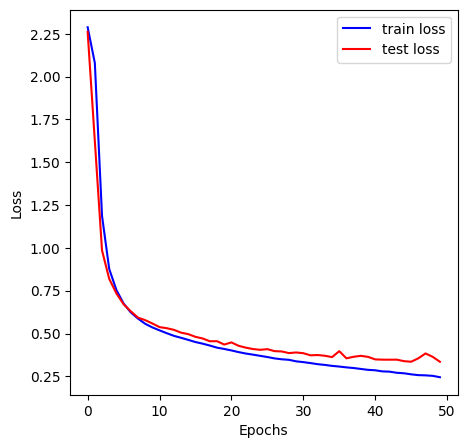

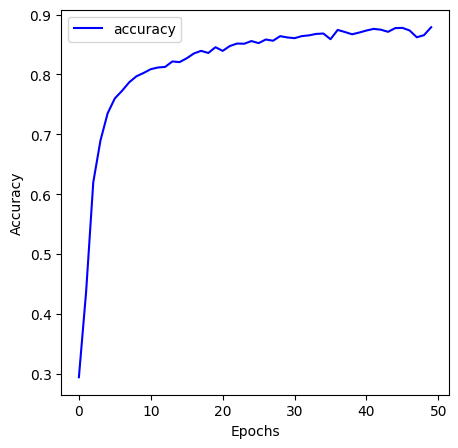

In [35]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn2-opt1")
plot_accuracy(accuracy, "nn2-opt1")

In [36]:
model3_o1 = NeuralNetwork3().to(device)
print(model3_o1)
count_parameters(model3_o1)
optimizer = torch.optim.SGD(model3_o1.parameters(), lr=1e-3, momentum=0.9)
results = train_model(model3_o1, loss_fn, optimizer, 50)

NeuralNetwork3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
1,083,338 total parameters.
1,083,338 training parameters.


100%|██████████| 469/469 [00:09<00:00, 50.21it/s]


Epoch: 01 | Time: 0m 10s | Train Loss: 2.180 | Test Loss: 1.836 | Accuracy: 30.2%


100%|██████████| 469/469 [00:10<00:00, 46.16it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 1.312 | Test Loss: 0.989 | Accuracy: 62.7%


100%|██████████| 469/469 [00:10<00:00, 46.40it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 0.868 | Test Loss: 0.803 | Accuracy: 69.6%


100%|██████████| 469/469 [00:09<00:00, 46.99it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 0.743 | Test Loss: 0.729 | Accuracy: 73.2%


100%|██████████| 469/469 [00:09<00:00, 47.15it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 0.668 | Test Loss: 0.658 | Accuracy: 76.5%


100%|██████████| 469/469 [00:10<00:00, 45.04it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 0.615 | Test Loss: 0.615 | Accuracy: 77.8%


100%|██████████| 469/469 [00:09<00:00, 47.02it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 0.579 | Test Loss: 0.584 | Accuracy: 79.4%


100%|██████████| 469/469 [00:10<00:00, 44.93it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 0.551 | Test Loss: 0.562 | Accuracy: 79.9%


100%|██████████| 469/469 [00:10<00:00, 44.87it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 0.527 | Test Loss: 0.540 | Accuracy: 80.7%


100%|██████████| 469/469 [00:10<00:00, 46.35it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 0.507 | Test Loss: 0.525 | Accuracy: 81.1%


100%|██████████| 469/469 [00:09<00:00, 47.22it/s]


Epoch: 11 | Time: 0m 11s | Train Loss: 0.490 | Test Loss: 0.508 | Accuracy: 82.0%


100%|██████████| 469/469 [00:10<00:00, 46.33it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 0.478 | Test Loss: 0.500 | Accuracy: 82.4%


100%|██████████| 469/469 [00:10<00:00, 46.43it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 0.465 | Test Loss: 0.488 | Accuracy: 82.6%


100%|██████████| 469/469 [00:09<00:00, 47.15it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 0.452 | Test Loss: 0.475 | Accuracy: 83.0%


100%|██████████| 469/469 [00:10<00:00, 45.08it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 0.444 | Test Loss: 0.472 | Accuracy: 83.2%


100%|██████████| 469/469 [00:10<00:00, 45.20it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 0.434 | Test Loss: 0.473 | Accuracy: 82.8%


100%|██████████| 469/469 [00:09<00:00, 47.74it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 0.425 | Test Loss: 0.452 | Accuracy: 83.8%


100%|██████████| 469/469 [00:09<00:00, 47.21it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 0.418 | Test Loss: 0.456 | Accuracy: 83.5%


100%|██████████| 469/469 [00:09<00:00, 46.99it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 0.413 | Test Loss: 0.446 | Accuracy: 84.0%


100%|██████████| 469/469 [00:09<00:00, 47.20it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 0.405 | Test Loss: 0.444 | Accuracy: 84.1%


100%|██████████| 469/469 [00:10<00:00, 45.36it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 0.400 | Test Loss: 0.429 | Accuracy: 84.8%


100%|██████████| 469/469 [00:10<00:00, 46.48it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 0.394 | Test Loss: 0.435 | Accuracy: 84.5%


100%|██████████| 469/469 [00:10<00:00, 45.10it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 0.390 | Test Loss: 0.431 | Accuracy: 84.4%


100%|██████████| 469/469 [00:10<00:00, 46.02it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 0.384 | Test Loss: 0.425 | Accuracy: 84.9%


100%|██████████| 469/469 [00:10<00:00, 45.39it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 0.377 | Test Loss: 0.415 | Accuracy: 85.0%


100%|██████████| 469/469 [00:09<00:00, 47.18it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 0.373 | Test Loss: 0.407 | Accuracy: 85.4%


100%|██████████| 469/469 [00:10<00:00, 46.43it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 0.369 | Test Loss: 0.405 | Accuracy: 85.3%


100%|██████████| 469/469 [00:10<00:00, 44.66it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 0.363 | Test Loss: 0.400 | Accuracy: 85.6%


100%|██████████| 469/469 [00:09<00:00, 46.91it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 0.360 | Test Loss: 0.431 | Accuracy: 85.0%


100%|██████████| 469/469 [00:09<00:00, 47.34it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 0.357 | Test Loss: 0.402 | Accuracy: 85.7%


100%|██████████| 469/469 [00:10<00:00, 45.79it/s]


Epoch: 31 | Time: 0m 11s | Train Loss: 0.352 | Test Loss: 0.398 | Accuracy: 85.7%


100%|██████████| 469/469 [00:09<00:00, 47.04it/s]


Epoch: 32 | Time: 0m 11s | Train Loss: 0.348 | Test Loss: 0.392 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 46.96it/s]


Epoch: 33 | Time: 0m 11s | Train Loss: 0.346 | Test Loss: 0.393 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 47.00it/s]


Epoch: 34 | Time: 0m 11s | Train Loss: 0.340 | Test Loss: 0.386 | Accuracy: 86.3%


100%|██████████| 469/469 [00:09<00:00, 46.93it/s]


Epoch: 35 | Time: 0m 11s | Train Loss: 0.337 | Test Loss: 0.379 | Accuracy: 86.4%


100%|██████████| 469/469 [00:10<00:00, 45.97it/s]


Epoch: 36 | Time: 0m 11s | Train Loss: 0.332 | Test Loss: 0.383 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 47.14it/s]


Epoch: 37 | Time: 0m 11s | Train Loss: 0.329 | Test Loss: 0.383 | Accuracy: 86.1%


100%|██████████| 469/469 [00:10<00:00, 44.88it/s]


Epoch: 38 | Time: 0m 11s | Train Loss: 0.327 | Test Loss: 0.372 | Accuracy: 86.7%


100%|██████████| 469/469 [00:09<00:00, 47.14it/s]


Epoch: 39 | Time: 0m 11s | Train Loss: 0.321 | Test Loss: 0.383 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 47.15it/s]


Epoch: 40 | Time: 0m 11s | Train Loss: 0.319 | Test Loss: 0.376 | Accuracy: 86.5%


100%|██████████| 469/469 [00:10<00:00, 46.88it/s]


Epoch: 41 | Time: 0m 11s | Train Loss: 0.315 | Test Loss: 0.368 | Accuracy: 86.6%


100%|██████████| 469/469 [00:10<00:00, 44.83it/s]


Epoch: 42 | Time: 0m 11s | Train Loss: 0.313 | Test Loss: 0.367 | Accuracy: 86.9%


100%|██████████| 469/469 [00:09<00:00, 47.37it/s]


Epoch: 43 | Time: 0m 11s | Train Loss: 0.310 | Test Loss: 0.372 | Accuracy: 86.7%


100%|██████████| 469/469 [00:10<00:00, 44.80it/s]


Epoch: 44 | Time: 0m 11s | Train Loss: 0.305 | Test Loss: 0.370 | Accuracy: 86.6%


100%|██████████| 469/469 [00:10<00:00, 45.15it/s]


Epoch: 45 | Time: 0m 11s | Train Loss: 0.304 | Test Loss: 0.362 | Accuracy: 87.0%


100%|██████████| 469/469 [00:09<00:00, 47.26it/s]


Epoch: 46 | Time: 0m 11s | Train Loss: 0.301 | Test Loss: 0.361 | Accuracy: 87.0%


100%|██████████| 469/469 [00:09<00:00, 47.10it/s]


Epoch: 47 | Time: 0m 11s | Train Loss: 0.295 | Test Loss: 0.360 | Accuracy: 87.1%


100%|██████████| 469/469 [00:10<00:00, 46.24it/s]


Epoch: 48 | Time: 0m 11s | Train Loss: 0.292 | Test Loss: 0.351 | Accuracy: 87.4%


100%|██████████| 469/469 [00:10<00:00, 45.18it/s]


Epoch: 49 | Time: 0m 11s | Train Loss: 0.289 | Test Loss: 0.353 | Accuracy: 87.4%


100%|██████████| 469/469 [00:09<00:00, 47.16it/s]


Epoch: 50 | Time: 0m 11s | Train Loss: 0.285 | Test Loss: 0.355 | Accuracy: 87.2%


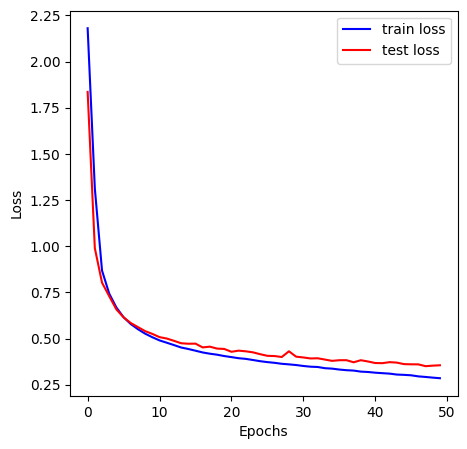

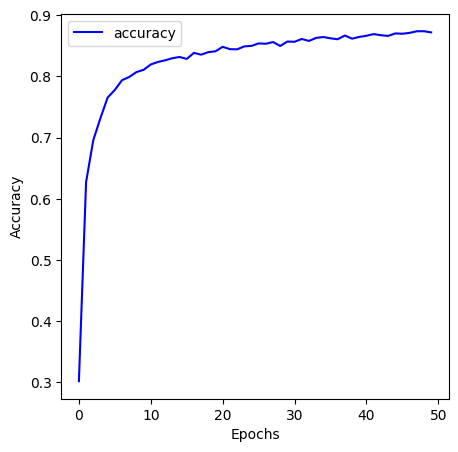

In [37]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn3-opt1")
plot_accuracy(accuracy, "nn3-opt1")

In [38]:
class NeuralNetwork3Tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.Tanh(),
            nn.Linear(1024, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [39]:
model3_tanh = NeuralNetwork3Tanh().to(device)
print(model3_tanh)
count_parameters(model3_tanh)
optimizer = torch.optim.SGD(model3_tanh.parameters(), lr=1e-3)
results = train_model(model3_tanh, loss_fn, optimizer, 50)

NeuralNetwork3Tanh(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
1,083,338 total parameters.
1,083,338 training parameters.


100%|██████████| 469/469 [00:10<00:00, 46.82it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 2.266 | Test Loss: 2.222 | Accuracy: 30.7%


100%|██████████| 469/469 [00:09<00:00, 48.74it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 2.177 | Test Loss: 2.131 | Accuracy: 44.7%


100%|██████████| 469/469 [00:09<00:00, 48.40it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 2.072 | Test Loss: 2.009 | Accuracy: 53.1%


100%|██████████| 469/469 [00:09<00:00, 47.74it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 1.929 | Test Loss: 1.848 | Accuracy: 57.5%


100%|██████████| 469/469 [00:09<00:00, 48.15it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 1.761 | Test Loss: 1.682 | Accuracy: 56.6%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 1.607 | Test Loss: 1.545 | Accuracy: 56.5%


100%|██████████| 469/469 [00:09<00:00, 48.13it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 1.486 | Test Loss: 1.438 | Accuracy: 57.7%


100%|██████████| 469/469 [00:09<00:00, 48.36it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 1.389 | Test Loss: 1.351 | Accuracy: 58.8%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 1.308 | Test Loss: 1.278 | Accuracy: 59.6%


100%|██████████| 469/469 [00:09<00:00, 48.20it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 1.240 | Test Loss: 1.215 | Accuracy: 61.0%


100%|██████████| 469/469 [00:09<00:00, 48.63it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 1.180 | Test Loss: 1.160 | Accuracy: 61.8%


100%|██████████| 469/469 [00:09<00:00, 48.39it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 1.128 | Test Loss: 1.112 | Accuracy: 62.9%


100%|██████████| 469/469 [00:09<00:00, 48.29it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 1.082 | Test Loss: 1.069 | Accuracy: 63.7%


100%|██████████| 469/469 [00:09<00:00, 48.05it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 1.041 | Test Loss: 1.031 | Accuracy: 64.5%


100%|██████████| 469/469 [00:09<00:00, 48.29it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 1.004 | Test Loss: 0.997 | Accuracy: 65.1%


100%|██████████| 469/469 [00:09<00:00, 48.18it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 0.972 | Test Loss: 0.967 | Accuracy: 65.8%


100%|██████████| 469/469 [00:09<00:00, 48.35it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 0.942 | Test Loss: 0.939 | Accuracy: 66.3%


100%|██████████| 469/469 [00:09<00:00, 48.14it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 0.915 | Test Loss: 0.914 | Accuracy: 66.9%


100%|██████████| 469/469 [00:09<00:00, 48.24it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 0.891 | Test Loss: 0.891 | Accuracy: 67.3%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 0.869 | Test Loss: 0.871 | Accuracy: 67.8%


100%|██████████| 469/469 [00:09<00:00, 48.41it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 0.849 | Test Loss: 0.852 | Accuracy: 68.4%


100%|██████████| 469/469 [00:09<00:00, 48.35it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 0.830 | Test Loss: 0.835 | Accuracy: 68.9%


100%|██████████| 469/469 [00:09<00:00, 48.44it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 0.814 | Test Loss: 0.820 | Accuracy: 69.4%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 0.798 | Test Loss: 0.805 | Accuracy: 69.8%


100%|██████████| 469/469 [00:09<00:00, 48.40it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 0.785 | Test Loss: 0.792 | Accuracy: 70.3%


100%|██████████| 469/469 [00:09<00:00, 47.96it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 0.772 | Test Loss: 0.780 | Accuracy: 70.9%


100%|██████████| 469/469 [00:09<00:00, 48.19it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 0.760 | Test Loss: 0.769 | Accuracy: 71.2%


100%|██████████| 469/469 [00:09<00:00, 48.48it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 0.749 | Test Loss: 0.759 | Accuracy: 71.6%


100%|██████████| 469/469 [00:09<00:00, 48.21it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 0.739 | Test Loss: 0.749 | Accuracy: 72.2%


100%|██████████| 469/469 [00:09<00:00, 48.10it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 0.729 | Test Loss: 0.740 | Accuracy: 72.6%


100%|██████████| 469/469 [00:09<00:00, 48.59it/s]


Epoch: 31 | Time: 0m 10s | Train Loss: 0.720 | Test Loss: 0.731 | Accuracy: 73.0%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 32 | Time: 0m 11s | Train Loss: 0.711 | Test Loss: 0.723 | Accuracy: 73.5%


100%|██████████| 469/469 [00:09<00:00, 48.34it/s]


Epoch: 33 | Time: 0m 11s | Train Loss: 0.703 | Test Loss: 0.715 | Accuracy: 73.8%


100%|██████████| 469/469 [00:09<00:00, 48.31it/s]


Epoch: 34 | Time: 0m 11s | Train Loss: 0.695 | Test Loss: 0.707 | Accuracy: 74.2%


100%|██████████| 469/469 [00:09<00:00, 47.91it/s]


Epoch: 35 | Time: 0m 11s | Train Loss: 0.687 | Test Loss: 0.700 | Accuracy: 74.5%


100%|██████████| 469/469 [00:09<00:00, 48.42it/s]


Epoch: 36 | Time: 0m 11s | Train Loss: 0.680 | Test Loss: 0.693 | Accuracy: 74.7%


100%|██████████| 469/469 [00:09<00:00, 48.00it/s]


Epoch: 37 | Time: 0m 11s | Train Loss: 0.672 | Test Loss: 0.685 | Accuracy: 75.1%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 38 | Time: 0m 11s | Train Loss: 0.665 | Test Loss: 0.679 | Accuracy: 75.5%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 39 | Time: 0m 11s | Train Loss: 0.658 | Test Loss: 0.672 | Accuracy: 75.8%


100%|██████████| 469/469 [00:09<00:00, 48.41it/s]


Epoch: 40 | Time: 0m 11s | Train Loss: 0.652 | Test Loss: 0.666 | Accuracy: 76.0%


100%|██████████| 469/469 [00:09<00:00, 48.18it/s]


Epoch: 41 | Time: 0m 11s | Train Loss: 0.645 | Test Loss: 0.659 | Accuracy: 76.3%


100%|██████████| 469/469 [00:09<00:00, 48.15it/s]


Epoch: 42 | Time: 0m 11s | Train Loss: 0.639 | Test Loss: 0.654 | Accuracy: 76.6%


100%|██████████| 469/469 [00:09<00:00, 48.13it/s]


Epoch: 43 | Time: 0m 11s | Train Loss: 0.633 | Test Loss: 0.648 | Accuracy: 77.0%


100%|██████████| 469/469 [00:09<00:00, 48.22it/s]


Epoch: 44 | Time: 0m 11s | Train Loss: 0.627 | Test Loss: 0.642 | Accuracy: 77.1%


100%|██████████| 469/469 [00:09<00:00, 48.28it/s]


Epoch: 45 | Time: 0m 11s | Train Loss: 0.621 | Test Loss: 0.637 | Accuracy: 77.2%


100%|██████████| 469/469 [00:09<00:00, 48.04it/s]


Epoch: 46 | Time: 0m 11s | Train Loss: 0.615 | Test Loss: 0.631 | Accuracy: 77.3%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 47 | Time: 0m 10s | Train Loss: 0.610 | Test Loss: 0.626 | Accuracy: 77.5%


100%|██████████| 469/469 [00:09<00:00, 48.05it/s]


Epoch: 48 | Time: 0m 11s | Train Loss: 0.605 | Test Loss: 0.621 | Accuracy: 77.7%


100%|██████████| 469/469 [00:09<00:00, 47.15it/s]


Epoch: 49 | Time: 0m 11s | Train Loss: 0.600 | Test Loss: 0.617 | Accuracy: 77.8%


100%|██████████| 469/469 [00:09<00:00, 49.50it/s]


Epoch: 50 | Time: 0m 10s | Train Loss: 0.595 | Test Loss: 0.612 | Accuracy: 78.1%


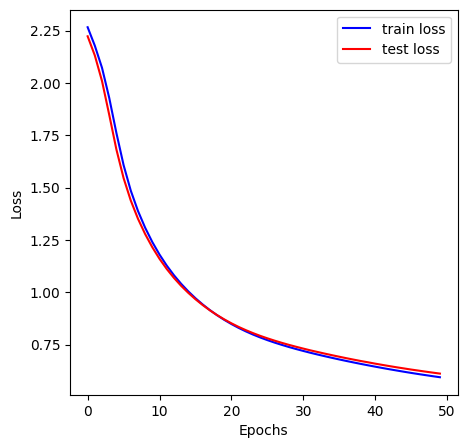

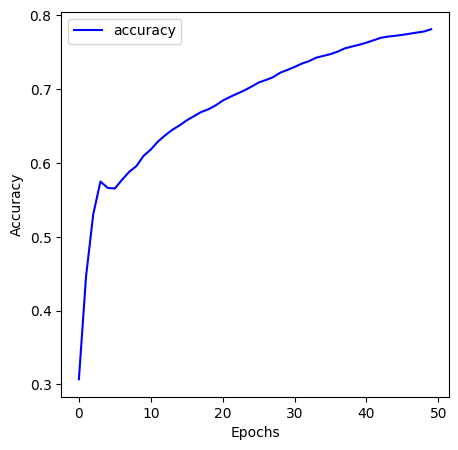

In [40]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn3-tanh")
plot_accuracy(accuracy, "nn3-tanh")

In [41]:
class NeuralNetwork3a(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [42]:
model3_adam = NeuralNetwork3a().to(device)
print(model3_adam)
count_parameters(model3_adam)
optimizer = torch.optim.Adam(model3_adam.parameters())
results = train_model(model3_adam, loss_fn, optimizer, 50)

NeuralNetwork3a(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)
1,083,338 total parameters.
1,083,338 training parameters.


  0%|          | 0/469 [00:00<?, ?it/s]d:\uni\nn\lab\.venv\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 469/469 [00:10<00:00, 46.04it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 1.706 | Test Loss: 1.643 | Accuracy: 81.7%


100%|██████████| 469/469 [00:09<00:00, 48.49it/s]


Epoch: 02 | Time: 0m 10s | Train Loss: 1.635 | Test Loss: 1.628 | Accuracy: 83.2%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 03 | Time: 0m 10s | Train Loss: 1.621 | Test Loss: 1.617 | Accuracy: 84.3%


100%|██████████| 469/469 [00:09<00:00, 48.33it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 1.614 | Test Loss: 1.658 | Accuracy: 80.2%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 05 | Time: 0m 10s | Train Loss: 1.609 | Test Loss: 1.616 | Accuracy: 84.4%


100%|██████████| 469/469 [00:09<00:00, 48.57it/s]


Epoch: 06 | Time: 0m 10s | Train Loss: 1.604 | Test Loss: 1.612 | Accuracy: 84.7%


100%|██████████| 469/469 [00:09<00:00, 48.66it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 1.600 | Test Loss: 1.610 | Accuracy: 85.0%


100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 1.599 | Test Loss: 1.615 | Accuracy: 84.5%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 09 | Time: 0m 10s | Train Loss: 1.598 | Test Loss: 1.602 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 48.53it/s]


Epoch: 10 | Time: 0m 10s | Train Loss: 1.597 | Test Loss: 1.626 | Accuracy: 83.4%


100%|██████████| 469/469 [00:09<00:00, 48.55it/s]


Epoch: 11 | Time: 0m 10s | Train Loss: 1.592 | Test Loss: 1.618 | Accuracy: 84.2%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 12 | Time: 0m 10s | Train Loss: 1.593 | Test Loss: 1.645 | Accuracy: 81.6%


100%|██████████| 469/469 [00:09<00:00, 48.48it/s]


Epoch: 13 | Time: 0m 10s | Train Loss: 1.593 | Test Loss: 1.605 | Accuracy: 85.6%


100%|██████████| 469/469 [00:09<00:00, 48.62it/s]


Epoch: 14 | Time: 0m 10s | Train Loss: 1.591 | Test Loss: 1.608 | Accuracy: 85.1%


100%|██████████| 469/469 [00:09<00:00, 48.53it/s]


Epoch: 15 | Time: 0m 10s | Train Loss: 1.595 | Test Loss: 1.602 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 48.38it/s]


Epoch: 16 | Time: 0m 10s | Train Loss: 1.588 | Test Loss: 1.647 | Accuracy: 81.3%


100%|██████████| 469/469 [00:09<00:00, 48.65it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 1.588 | Test Loss: 1.606 | Accuracy: 85.4%


100%|██████████| 469/469 [00:09<00:00, 48.71it/s]


Epoch: 18 | Time: 0m 10s | Train Loss: 1.585 | Test Loss: 1.595 | Accuracy: 86.5%


100%|██████████| 469/469 [00:09<00:00, 48.31it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 1.587 | Test Loss: 1.604 | Accuracy: 85.7%


100%|██████████| 469/469 [00:09<00:00, 48.21it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 1.588 | Test Loss: 1.605 | Accuracy: 85.5%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 21 | Time: 0m 10s | Train Loss: 1.583 | Test Loss: 1.601 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 48.20it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 1.586 | Test Loss: 1.602 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 48.44it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 1.585 | Test Loss: 1.592 | Accuracy: 86.9%


100%|██████████| 469/469 [00:09<00:00, 48.55it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 1.584 | Test Loss: 1.600 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 48.40it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 1.581 | Test Loss: 1.600 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 48.56it/s]


Epoch: 26 | Time: 0m 10s | Train Loss: 1.580 | Test Loss: 1.599 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 48.36it/s]


Epoch: 27 | Time: 0m 10s | Train Loss: 1.581 | Test Loss: 1.598 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 48.32it/s]


Epoch: 28 | Time: 0m 10s | Train Loss: 1.584 | Test Loss: 1.611 | Accuracy: 84.8%


100%|██████████| 469/469 [00:09<00:00, 48.59it/s]


Epoch: 29 | Time: 0m 10s | Train Loss: 1.580 | Test Loss: 1.594 | Accuracy: 86.7%


100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


Epoch: 30 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.596 | Accuracy: 86.5%


100%|██████████| 469/469 [00:09<00:00, 48.38it/s]


Epoch: 31 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.597 | Accuracy: 86.4%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 32 | Time: 0m 10s | Train Loss: 1.585 | Test Loss: 1.600 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 48.59it/s]


Epoch: 33 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.608 | Accuracy: 85.3%


100%|██████████| 469/469 [00:09<00:00, 48.57it/s]


Epoch: 34 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.592 | Accuracy: 86.9%


100%|██████████| 469/469 [00:09<00:00, 48.62it/s]


Epoch: 35 | Time: 0m 10s | Train Loss: 1.590 | Test Loss: 1.616 | Accuracy: 84.5%


100%|██████████| 469/469 [00:09<00:00, 48.49it/s]


Epoch: 36 | Time: 0m 10s | Train Loss: 1.583 | Test Loss: 1.605 | Accuracy: 85.4%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 37 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.643 | Accuracy: 81.8%


100%|██████████| 469/469 [00:09<00:00, 48.39it/s]


Epoch: 38 | Time: 0m 10s | Train Loss: 1.587 | Test Loss: 1.609 | Accuracy: 85.2%


100%|██████████| 469/469 [00:09<00:00, 48.35it/s]


Epoch: 39 | Time: 0m 11s | Train Loss: 1.587 | Test Loss: 1.613 | Accuracy: 84.7%


100%|██████████| 469/469 [00:09<00:00, 48.50it/s]


Epoch: 40 | Time: 0m 10s | Train Loss: 1.588 | Test Loss: 1.603 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 48.52it/s]


Epoch: 41 | Time: 0m 10s | Train Loss: 1.585 | Test Loss: 1.603 | Accuracy: 85.6%


100%|██████████| 469/469 [00:09<00:00, 48.43it/s]


Epoch: 42 | Time: 0m 10s | Train Loss: 1.587 | Test Loss: 1.617 | Accuracy: 84.4%


100%|██████████| 469/469 [00:09<00:00, 48.83it/s]


Epoch: 43 | Time: 0m 10s | Train Loss: 1.587 | Test Loss: 1.594 | Accuracy: 86.7%


100%|██████████| 469/469 [00:09<00:00, 48.31it/s]


Epoch: 44 | Time: 0m 11s | Train Loss: 1.583 | Test Loss: 1.594 | Accuracy: 86.7%


100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


Epoch: 45 | Time: 0m 10s | Train Loss: 1.584 | Test Loss: 1.602 | Accuracy: 85.9%


100%|██████████| 469/469 [00:09<00:00, 48.67it/s]


Epoch: 46 | Time: 0m 10s | Train Loss: 1.587 | Test Loss: 1.607 | Accuracy: 85.4%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 47 | Time: 0m 10s | Train Loss: 1.587 | Test Loss: 1.599 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 48.64it/s]


Epoch: 48 | Time: 0m 10s | Train Loss: 1.589 | Test Loss: 1.599 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 48.62it/s]


Epoch: 49 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.631 | Accuracy: 82.8%


100%|██████████| 469/469 [00:09<00:00, 48.69it/s]


Epoch: 50 | Time: 0m 10s | Train Loss: 1.586 | Test Loss: 1.607 | Accuracy: 85.4%


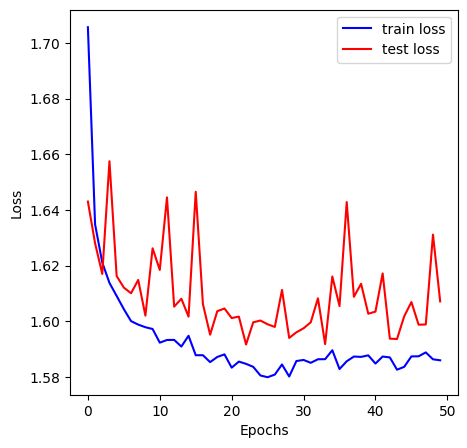

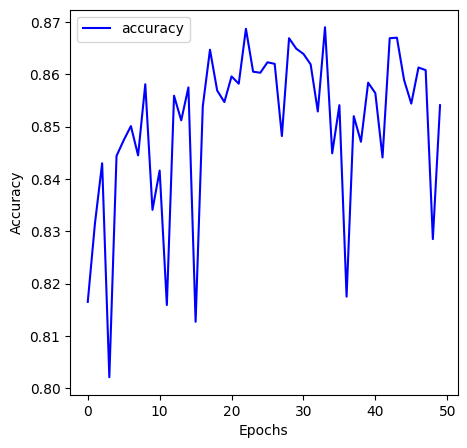

In [43]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn3-adam")
plot_accuracy(accuracy, "nn3-adam")

In [44]:
model3_adam2 = NeuralNetwork3a().to(device)
print(model3_adam2)
count_parameters(model3_adam2)
optimizer = torch.optim.Adam(model3_adam2.parameters(), lr=1e-4, betas=(0.95, 0.999), weight_decay=1e-4)
results = train_model(model3_adam2, loss_fn, optimizer, 50)

NeuralNetwork3a(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)
1,083,338 total parameters.
1,083,338 training parameters.


100%|██████████| 469/469 [00:10<00:00, 46.34it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 1.869 | Test Loss: 1.709 | Accuracy: 76.5%


100%|██████████| 469/469 [00:09<00:00, 47.41it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 1.683 | Test Loss: 1.671 | Accuracy: 80.2%


100%|██████████| 469/469 [00:09<00:00, 47.55it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 1.651 | Test Loss: 1.652 | Accuracy: 81.6%


100%|██████████| 469/469 [00:09<00:00, 47.32it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 1.636 | Test Loss: 1.638 | Accuracy: 83.0%


100%|██████████| 469/469 [00:09<00:00, 47.45it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 1.627 | Test Loss: 1.637 | Accuracy: 82.9%


100%|██████████| 469/469 [00:09<00:00, 47.92it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 1.621 | Test Loss: 1.633 | Accuracy: 83.1%


100%|██████████| 469/469 [00:09<00:00, 47.25it/s]


Epoch: 07 | Time: 0m 11s | Train Loss: 1.614 | Test Loss: 1.622 | Accuracy: 84.4%


100%|██████████| 469/469 [00:09<00:00, 47.94it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 1.610 | Test Loss: 1.619 | Accuracy: 84.7%


100%|██████████| 469/469 [00:09<00:00, 47.52it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 1.607 | Test Loss: 1.621 | Accuracy: 84.2%


100%|██████████| 469/469 [00:09<00:00, 47.43it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 1.605 | Test Loss: 1.623 | Accuracy: 84.1%


100%|██████████| 469/469 [00:09<00:00, 47.28it/s]


Epoch: 11 | Time: 0m 11s | Train Loss: 1.601 | Test Loss: 1.613 | Accuracy: 85.2%


100%|██████████| 469/469 [00:09<00:00, 47.78it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 1.598 | Test Loss: 1.611 | Accuracy: 85.4%


100%|██████████| 469/469 [00:10<00:00, 46.83it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 1.597 | Test Loss: 1.608 | Accuracy: 85.5%


100%|██████████| 469/469 [00:09<00:00, 47.48it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 1.594 | Test Loss: 1.606 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 47.18it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 1.591 | Test Loss: 1.604 | Accuracy: 86.1%


100%|██████████| 469/469 [00:09<00:00, 47.96it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 1.590 | Test Loss: 1.605 | Accuracy: 85.9%


100%|██████████| 469/469 [00:09<00:00, 51.04it/s]


Epoch: 17 | Time: 0m 10s | Train Loss: 1.588 | Test Loss: 1.608 | Accuracy: 85.7%


100%|██████████| 469/469 [00:09<00:00, 47.42it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 1.586 | Test Loss: 1.604 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 47.31it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 1.585 | Test Loss: 1.602 | Accuracy: 86.2%


100%|██████████| 469/469 [00:09<00:00, 47.26it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 1.582 | Test Loss: 1.603 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 47.88it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 1.581 | Test Loss: 1.606 | Accuracy: 85.5%


100%|██████████| 469/469 [00:09<00:00, 47.24it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 1.580 | Test Loss: 1.599 | Accuracy: 86.5%


100%|██████████| 469/469 [00:09<00:00, 47.87it/s]


Epoch: 23 | Time: 0m 11s | Train Loss: 1.578 | Test Loss: 1.599 | Accuracy: 86.5%


100%|██████████| 469/469 [00:09<00:00, 47.58it/s]


Epoch: 24 | Time: 0m 11s | Train Loss: 1.578 | Test Loss: 1.604 | Accuracy: 85.8%


100%|██████████| 469/469 [00:09<00:00, 47.69it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 1.575 | Test Loss: 1.594 | Accuracy: 86.8%


100%|██████████| 469/469 [00:09<00:00, 47.20it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 1.576 | Test Loss: 1.602 | Accuracy: 85.9%


100%|██████████| 469/469 [00:10<00:00, 44.38it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 1.572 | Test Loss: 1.592 | Accuracy: 87.2%


100%|██████████| 469/469 [00:10<00:00, 46.69it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 1.573 | Test Loss: 1.594 | Accuracy: 87.0%


100%|██████████| 469/469 [00:10<00:00, 46.69it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 1.571 | Test Loss: 1.592 | Accuracy: 87.0%


100%|██████████| 469/469 [00:10<00:00, 46.10it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 1.569 | Test Loss: 1.590 | Accuracy: 87.3%


100%|██████████| 469/469 [00:10<00:00, 46.79it/s]


Epoch: 31 | Time: 0m 11s | Train Loss: 1.568 | Test Loss: 1.591 | Accuracy: 87.2%


100%|██████████| 469/469 [00:10<00:00, 46.20it/s]


Epoch: 32 | Time: 0m 11s | Train Loss: 1.567 | Test Loss: 1.600 | Accuracy: 86.3%


100%|██████████| 469/469 [00:10<00:00, 46.69it/s]


Epoch: 33 | Time: 0m 11s | Train Loss: 1.567 | Test Loss: 1.592 | Accuracy: 87.1%


100%|██████████| 469/469 [00:10<00:00, 46.73it/s]


Epoch: 34 | Time: 0m 11s | Train Loss: 1.567 | Test Loss: 1.597 | Accuracy: 86.6%


100%|██████████| 469/469 [00:10<00:00, 45.89it/s]


Epoch: 35 | Time: 0m 11s | Train Loss: 1.564 | Test Loss: 1.590 | Accuracy: 87.2%


100%|██████████| 469/469 [00:10<00:00, 46.73it/s]


Epoch: 36 | Time: 0m 11s | Train Loss: 1.563 | Test Loss: 1.588 | Accuracy: 87.6%


100%|██████████| 469/469 [00:10<00:00, 46.34it/s]


Epoch: 37 | Time: 0m 11s | Train Loss: 1.563 | Test Loss: 1.585 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 46.40it/s]


Epoch: 38 | Time: 0m 11s | Train Loss: 1.562 | Test Loss: 1.589 | Accuracy: 87.2%


100%|██████████| 469/469 [00:10<00:00, 46.55it/s]


Epoch: 39 | Time: 0m 11s | Train Loss: 1.561 | Test Loss: 1.587 | Accuracy: 87.6%


100%|██████████| 469/469 [00:10<00:00, 46.40it/s]


Epoch: 40 | Time: 0m 11s | Train Loss: 1.560 | Test Loss: 1.586 | Accuracy: 87.6%


100%|██████████| 469/469 [00:10<00:00, 46.59it/s]


Epoch: 41 | Time: 0m 11s | Train Loss: 1.559 | Test Loss: 1.586 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 46.34it/s]


Epoch: 42 | Time: 0m 11s | Train Loss: 1.559 | Test Loss: 1.585 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 46.36it/s]


Epoch: 43 | Time: 0m 11s | Train Loss: 1.558 | Test Loss: 1.585 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 46.28it/s]


Epoch: 44 | Time: 0m 11s | Train Loss: 1.557 | Test Loss: 1.585 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 46.32it/s]


Epoch: 45 | Time: 0m 11s | Train Loss: 1.556 | Test Loss: 1.585 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 46.75it/s]


Epoch: 46 | Time: 0m 11s | Train Loss: 1.555 | Test Loss: 1.582 | Accuracy: 88.0%


100%|██████████| 469/469 [00:10<00:00, 46.65it/s]


Epoch: 47 | Time: 0m 11s | Train Loss: 1.556 | Test Loss: 1.584 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 46.41it/s]


Epoch: 48 | Time: 0m 11s | Train Loss: 1.553 | Test Loss: 1.586 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 46.61it/s]


Epoch: 49 | Time: 0m 11s | Train Loss: 1.554 | Test Loss: 1.591 | Accuracy: 87.2%


100%|██████████| 469/469 [00:10<00:00, 46.48it/s]


Epoch: 50 | Time: 0m 11s | Train Loss: 1.552 | Test Loss: 1.583 | Accuracy: 87.8%


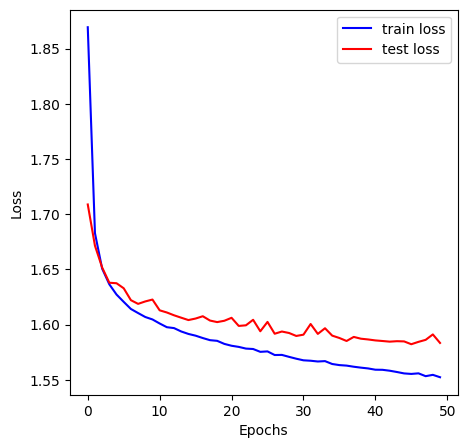

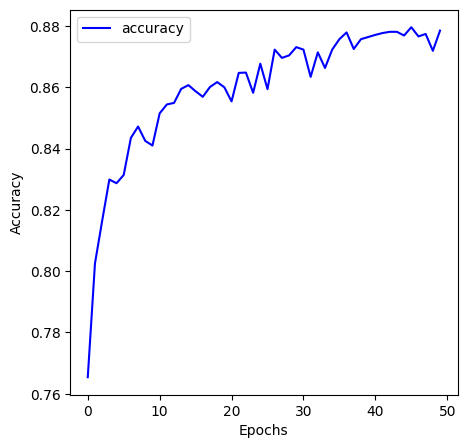

In [45]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn3-adam2")
plot_accuracy(accuracy, "nn3-adam2")

In [46]:
class NeuralNetwork5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, 3),  # 26
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 13
            nn.Conv2d(8, 16, 3),  # 11
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [47]:
model5 = NeuralNetwork5().to(device)
print(model5)
count_parameters(model5)
optimizer = torch.optim.Adam(model5.parameters())
results = train_model(model5, loss_fn, optimizer, 30)

NeuralNetwork5(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=None)
  )
)
273,514 total parameters.
273,514 training parameters.


100%|██████████| 469/469 [00:10<00:00, 43.04it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.791 | Test Loss: 1.730 | Accuracy: 72.9%


100%|██████████| 469/469 [00:09<00:00, 48.68it/s]


Epoch: 02 | Time: 0m 11s | Train Loss: 1.699 | Test Loss: 1.691 | Accuracy: 76.8%


100%|██████████| 469/469 [00:09<00:00, 48.66it/s]


Epoch: 03 | Time: 0m 11s | Train Loss: 1.682 | Test Loss: 1.680 | Accuracy: 77.6%


100%|██████████| 469/469 [00:09<00:00, 48.50it/s]


Epoch: 04 | Time: 0m 11s | Train Loss: 1.632 | Test Loss: 1.630 | Accuracy: 83.0%


100%|██████████| 469/469 [00:09<00:00, 48.36it/s]


Epoch: 05 | Time: 0m 11s | Train Loss: 1.608 | Test Loss: 1.609 | Accuracy: 85.0%


100%|██████████| 469/469 [00:09<00:00, 48.37it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 1.596 | Test Loss: 1.600 | Accuracy: 86.0%


100%|██████████| 469/469 [00:09<00:00, 49.04it/s]


Epoch: 07 | Time: 0m 10s | Train Loss: 1.589 | Test Loss: 1.593 | Accuracy: 86.9%


100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


Epoch: 08 | Time: 0m 11s | Train Loss: 1.587 | Test Loss: 1.592 | Accuracy: 86.8%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 09 | Time: 0m 11s | Train Loss: 1.581 | Test Loss: 1.596 | Accuracy: 86.4%


100%|██████████| 469/469 [00:09<00:00, 48.33it/s]


Epoch: 10 | Time: 0m 11s | Train Loss: 1.576 | Test Loss: 1.590 | Accuracy: 87.1%


100%|██████████| 469/469 [00:09<00:00, 48.47it/s]


Epoch: 11 | Time: 0m 11s | Train Loss: 1.574 | Test Loss: 1.593 | Accuracy: 86.8%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 12 | Time: 0m 11s | Train Loss: 1.569 | Test Loss: 1.590 | Accuracy: 87.0%


100%|██████████| 469/469 [00:09<00:00, 48.36it/s]


Epoch: 13 | Time: 0m 11s | Train Loss: 1.566 | Test Loss: 1.589 | Accuracy: 87.2%


100%|██████████| 469/469 [00:09<00:00, 48.75it/s]


Epoch: 14 | Time: 0m 11s | Train Loss: 1.563 | Test Loss: 1.580 | Accuracy: 88.2%


100%|██████████| 469/469 [00:09<00:00, 48.96it/s]


Epoch: 15 | Time: 0m 11s | Train Loss: 1.561 | Test Loss: 1.580 | Accuracy: 88.1%


100%|██████████| 469/469 [00:09<00:00, 48.72it/s]


Epoch: 16 | Time: 0m 11s | Train Loss: 1.558 | Test Loss: 1.576 | Accuracy: 88.5%


100%|██████████| 469/469 [00:09<00:00, 48.23it/s]


Epoch: 17 | Time: 0m 11s | Train Loss: 1.557 | Test Loss: 1.575 | Accuracy: 88.6%


100%|██████████| 469/469 [00:09<00:00, 48.77it/s]


Epoch: 18 | Time: 0m 11s | Train Loss: 1.554 | Test Loss: 1.575 | Accuracy: 88.7%


100%|██████████| 469/469 [00:09<00:00, 48.27it/s]


Epoch: 19 | Time: 0m 11s | Train Loss: 1.553 | Test Loss: 1.575 | Accuracy: 88.6%


100%|██████████| 469/469 [00:09<00:00, 48.42it/s]


Epoch: 20 | Time: 0m 11s | Train Loss: 1.549 | Test Loss: 1.568 | Accuracy: 89.4%


100%|██████████| 469/469 [00:10<00:00, 46.79it/s]


Epoch: 21 | Time: 0m 11s | Train Loss: 1.548 | Test Loss: 1.567 | Accuracy: 89.4%


100%|██████████| 469/469 [00:09<00:00, 48.34it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 1.549 | Test Loss: 1.577 | Accuracy: 88.3%


100%|██████████| 469/469 [00:09<00:00, 48.90it/s]


Epoch: 23 | Time: 0m 10s | Train Loss: 1.546 | Test Loss: 1.568 | Accuracy: 89.3%


100%|██████████| 469/469 [00:09<00:00, 48.94it/s]


Epoch: 24 | Time: 0m 10s | Train Loss: 1.545 | Test Loss: 1.569 | Accuracy: 89.3%


100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


Epoch: 25 | Time: 0m 11s | Train Loss: 1.542 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:09<00:00, 49.10it/s]


Epoch: 26 | Time: 0m 11s | Train Loss: 1.542 | Test Loss: 1.569 | Accuracy: 89.3%


100%|██████████| 469/469 [00:09<00:00, 48.37it/s]


Epoch: 27 | Time: 0m 11s | Train Loss: 1.542 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:09<00:00, 48.08it/s]


Epoch: 28 | Time: 0m 11s | Train Loss: 1.541 | Test Loss: 1.567 | Accuracy: 89.5%


100%|██████████| 469/469 [00:09<00:00, 48.23it/s]


Epoch: 29 | Time: 0m 11s | Train Loss: 1.538 | Test Loss: 1.562 | Accuracy: 89.9%


100%|██████████| 469/469 [00:09<00:00, 48.27it/s]


Epoch: 30 | Time: 0m 11s | Train Loss: 1.537 | Test Loss: 1.565 | Accuracy: 89.5%


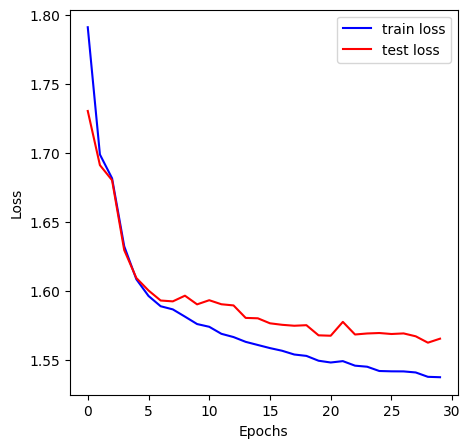

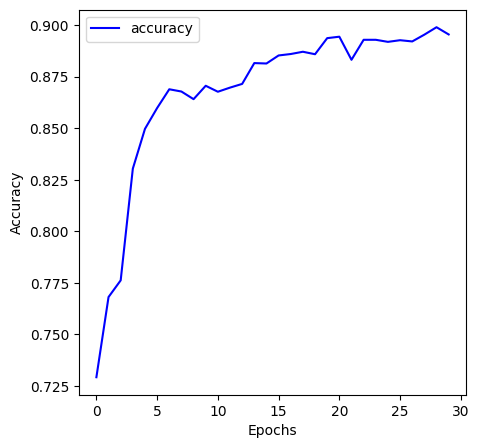

In [48]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn5")
plot_accuracy(accuracy, "nn5")

In [49]:
class NeuralNetwork6(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3),  # 26
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),  # 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 12
            nn.Flatten(),
            nn.Linear(32 * 12 * 12, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [50]:
model6 = NeuralNetwork6().to(device)
print(model6)
count_parameters(model6)
optimizer = torch.optim.Adam(model6.parameters())
results = train_model(model6, loss_fn, optimizer, 30)

NeuralNetwork6(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4608, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=10, bias=True)
    (11): Softmax(dim=None)
  )
)
4,989,386 total parameters.
4,989,386 training parameters.


100%|██████████| 469/469 [00:10<00:00, 43.15it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.688 | Test Loss: 1.619 | Accuracy: 84.5%


100%|██████████| 469/469 [00:10<00:00, 43.02it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.594 | Test Loss: 1.592 | Accuracy: 87.0%


100%|██████████| 469/469 [00:11<00:00, 42.59it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.578 | Test Loss: 1.595 | Accuracy: 86.5%


100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.566 | Test Loss: 1.574 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 42.87it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.559 | Test Loss: 1.572 | Accuracy: 88.9%


100%|██████████| 469/469 [00:10<00:00, 42.92it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.566 | Accuracy: 89.4%


100%|██████████| 469/469 [00:10<00:00, 42.84it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.567 | Accuracy: 89.4%


100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.542 | Test Loss: 1.563 | Accuracy: 89.9%


100%|██████████| 469/469 [00:10<00:00, 42.88it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.557 | Accuracy: 90.4%


100%|██████████| 469/469 [00:10<00:00, 42.76it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.534 | Test Loss: 1.563 | Accuracy: 89.8%


100%|██████████| 469/469 [00:10<00:00, 42.81it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.553 | Accuracy: 90.9%


100%|██████████| 469/469 [00:10<00:00, 42.75it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.527 | Test Loss: 1.555 | Accuracy: 90.7%


100%|██████████| 469/469 [00:10<00:00, 43.16it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.524 | Test Loss: 1.554 | Accuracy: 90.7%


100%|██████████| 469/469 [00:10<00:00, 42.74it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.523 | Test Loss: 1.550 | Accuracy: 91.1%


100%|██████████| 469/469 [00:10<00:00, 42.82it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.520 | Test Loss: 1.550 | Accuracy: 91.2%


100%|██████████| 469/469 [00:10<00:00, 43.04it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.518 | Test Loss: 1.553 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.516 | Test Loss: 1.557 | Accuracy: 90.5%


100%|██████████| 469/469 [00:10<00:00, 42.94it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.514 | Test Loss: 1.554 | Accuracy: 90.6%


100%|██████████| 469/469 [00:10<00:00, 42.84it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.512 | Test Loss: 1.548 | Accuracy: 91.3%


100%|██████████| 469/469 [00:10<00:00, 42.82it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.511 | Test Loss: 1.552 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.25it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.510 | Test Loss: 1.556 | Accuracy: 90.5%


100%|██████████| 469/469 [00:10<00:00, 42.65it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.508 | Test Loss: 1.549 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.60it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.510 | Test Loss: 1.551 | Accuracy: 91.1%


100%|██████████| 469/469 [00:10<00:00, 42.73it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.506 | Test Loss: 1.547 | Accuracy: 91.5%


100%|██████████| 469/469 [00:10<00:00, 42.70it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.506 | Test Loss: 1.545 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 42.59it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.506 | Test Loss: 1.546 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.505 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 42.39it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.506 | Test Loss: 1.548 | Accuracy: 91.4%


100%|██████████| 469/469 [00:11<00:00, 42.59it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.504 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.32it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.502 | Test Loss: 1.543 | Accuracy: 91.8%


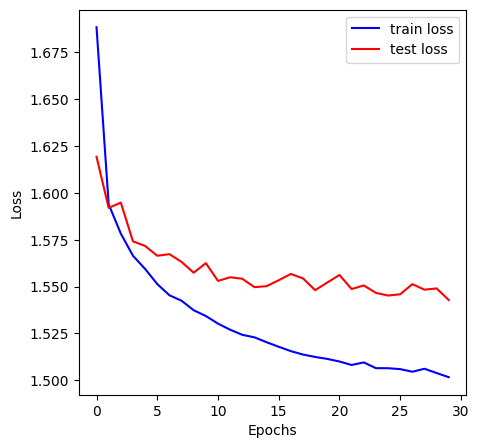

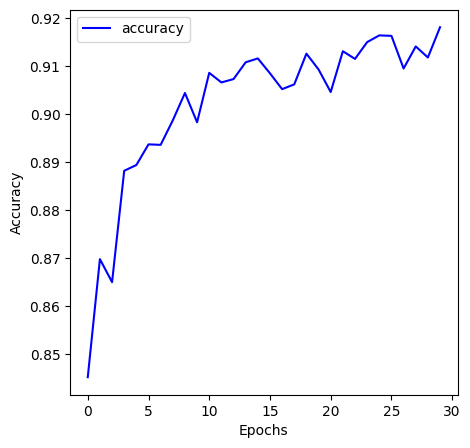

In [51]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn6")
plot_accuracy(accuracy, "nn6")

In [52]:
class NeuralNetwork6d(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3),  # 26
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),  # 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 12
            nn.Flatten(),
            nn.Linear(32 * 12 * 12, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [53]:
model6d = NeuralNetwork6d().to(device)
print(model6d)
count_parameters(model6d)
optimizer = torch.optim.Adam(model6d.parameters())
results = train_model(model6d, loss_fn, optimizer, 30)

NeuralNetwork6d(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4608, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1024, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=10, bias=True)
    (13): Softmax(dim=None)
  )
)
4,989,386 total parameters.
4,989,386 training parameters.


100%|██████████| 469/469 [00:11<00:00, 42.41it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.776 | Test Loss: 1.710 | Accuracy: 75.1%


100%|██████████| 469/469 [00:10<00:00, 43.02it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.634 | Test Loss: 1.597 | Accuracy: 86.3%


100%|██████████| 469/469 [00:10<00:00, 42.98it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.587 | Test Loss: 1.583 | Accuracy: 87.9%


100%|██████████| 469/469 [00:10<00:00, 43.02it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.572 | Test Loss: 1.573 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.563 | Test Loss: 1.573 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 43.00it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.555 | Test Loss: 1.565 | Accuracy: 89.6%


100%|██████████| 469/469 [00:10<00:00, 42.87it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.561 | Accuracy: 90.1%


100%|██████████| 469/469 [00:10<00:00, 43.39it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.544 | Test Loss: 1.561 | Accuracy: 89.9%


100%|██████████| 469/469 [00:10<00:00, 43.11it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.539 | Test Loss: 1.554 | Accuracy: 90.6%


100%|██████████| 469/469 [00:10<00:00, 43.08it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.556 | Accuracy: 90.5%


100%|██████████| 469/469 [00:10<00:00, 42.89it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.534 | Test Loss: 1.551 | Accuracy: 91.1%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.554 | Accuracy: 90.5%


100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.528 | Test Loss: 1.551 | Accuracy: 90.9%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.525 | Test Loss: 1.547 | Accuracy: 91.5%


100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.522 | Test Loss: 1.548 | Accuracy: 91.4%


100%|██████████| 469/469 [00:10<00:00, 43.37it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.519 | Test Loss: 1.545 | Accuracy: 91.6%


100%|██████████| 469/469 [00:10<00:00, 43.01it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.519 | Test Loss: 1.546 | Accuracy: 91.5%


100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.515 | Test Loss: 1.542 | Accuracy: 91.9%


100%|██████████| 469/469 [00:10<00:00, 43.03it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.514 | Test Loss: 1.544 | Accuracy: 91.7%


100%|██████████| 469/469 [00:10<00:00, 43.07it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.513 | Test Loss: 1.546 | Accuracy: 91.6%


100%|██████████| 469/469 [00:10<00:00, 43.03it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.513 | Test Loss: 1.560 | Accuracy: 90.2%


100%|██████████| 469/469 [00:10<00:00, 43.05it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.511 | Test Loss: 1.546 | Accuracy: 91.5%


100%|██████████| 469/469 [00:10<00:00, 43.19it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.511 | Test Loss: 1.546 | Accuracy: 91.5%


100%|██████████| 469/469 [00:10<00:00, 43.16it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.510 | Test Loss: 1.548 | Accuracy: 91.4%


100%|██████████| 469/469 [00:10<00:00, 42.96it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.508 | Test Loss: 1.544 | Accuracy: 91.7%


100%|██████████| 469/469 [00:10<00:00, 42.64it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.509 | Test Loss: 1.547 | Accuracy: 91.4%


100%|██████████| 469/469 [00:10<00:00, 42.74it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.507 | Test Loss: 1.542 | Accuracy: 91.8%


100%|██████████| 469/469 [00:10<00:00, 42.92it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.506 | Test Loss: 1.544 | Accuracy: 91.7%


100%|██████████| 469/469 [00:10<00:00, 42.82it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.508 | Test Loss: 1.540 | Accuracy: 92.0%


100%|██████████| 469/469 [00:10<00:00, 42.81it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.505 | Test Loss: 1.544 | Accuracy: 91.6%


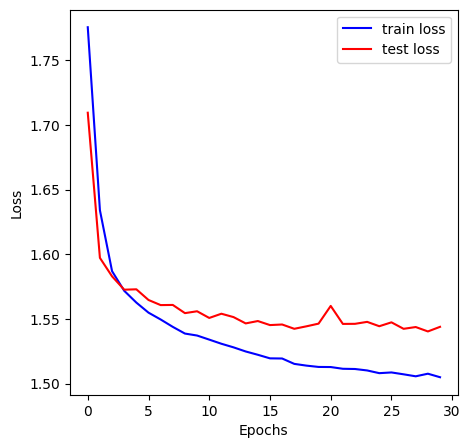

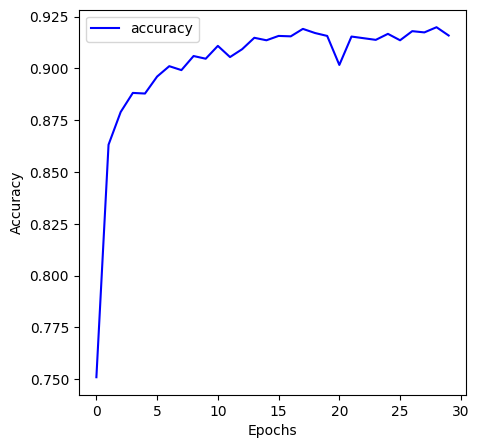

In [54]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn6-d")
plot_accuracy(accuracy, "nn6-d")

In [55]:
class NeuralNetwork7(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3),  # 26
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),  # 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 12
            nn.Conv2d(32, 64, 3),  # 10
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),  # 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 4
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [56]:
model7 = NeuralNetwork7().to(device)
print(model7)
count_parameters(model7)
optimizer = torch.optim.Adam(model7.parameters())
results = train_model(model7, loss_fn, optimizer, 50)

NeuralNetwork7(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=10, bias=True)
    (16): Softmax(dim=None)
  )
)
651,978 total parameters.
651,978 training parameters.


  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:11<00:00, 42.33it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.792 | Test Loss: 1.729 | Accuracy: 72.9%


100%|██████████| 469/469 [00:10<00:00, 43.11it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.668 | Test Loss: 1.649 | Accuracy: 81.2%


100%|██████████| 469/469 [00:10<00:00, 43.23it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.626 | Test Loss: 1.623 | Accuracy: 83.7%


100%|██████████| 469/469 [00:10<00:00, 43.23it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.612 | Test Loss: 1.609 | Accuracy: 85.0%


100%|██████████| 469/469 [00:10<00:00, 43.17it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.602 | Test Loss: 1.601 | Accuracy: 85.9%


100%|██████████| 469/469 [00:10<00:00, 43.24it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.597 | Test Loss: 1.602 | Accuracy: 85.8%


100%|██████████| 469/469 [00:10<00:00, 43.59it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.586 | Test Loss: 1.589 | Accuracy: 87.1%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.578 | Test Loss: 1.589 | Accuracy: 87.1%


100%|██████████| 469/469 [00:10<00:00, 43.37it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.571 | Test Loss: 1.580 | Accuracy: 88.1%


100%|██████████| 469/469 [00:10<00:00, 43.12it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.569 | Test Loss: 1.582 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 43.15it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.564 | Test Loss: 1.567 | Accuracy: 89.1%


100%|██████████| 469/469 [00:10<00:00, 43.34it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.562 | Test Loss: 1.566 | Accuracy: 89.3%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.573 | Accuracy: 88.7%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.578 | Accuracy: 88.2%


100%|██████████| 469/469 [00:10<00:00, 43.13it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.554 | Test Loss: 1.568 | Accuracy: 89.2%


100%|██████████| 469/469 [00:10<00:00, 43.02it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.556 | Test Loss: 1.567 | Accuracy: 89.3%


100%|██████████| 469/469 [00:10<00:00, 42.96it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.564 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 43.26it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.565 | Accuracy: 89.5%


100%|██████████| 469/469 [00:10<00:00, 43.05it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.572 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 43.05it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.569 | Accuracy: 89.1%


100%|██████████| 469/469 [00:10<00:00, 43.20it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.563 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 46.05it/s]


Epoch: 22 | Time: 0m 11s | Train Loss: 1.550 | Test Loss: 1.562 | Accuracy: 89.8%


100%|██████████| 469/469 [00:10<00:00, 42.79it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.563 | Accuracy: 89.8%


100%|██████████| 469/469 [00:10<00:00, 42.90it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.563 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 43.37it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.566 | Accuracy: 89.4%


100%|██████████| 469/469 [00:10<00:00, 42.90it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.564 | Accuracy: 89.6%


100%|██████████| 469/469 [00:10<00:00, 43.05it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.562 | Accuracy: 89.9%


100%|██████████| 469/469 [00:10<00:00, 42.85it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.562 | Accuracy: 89.8%


100%|██████████| 469/469 [00:10<00:00, 42.92it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.566 | Accuracy: 89.6%


100%|██████████| 469/469 [00:10<00:00, 42.89it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.572 | Accuracy: 88.9%


100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.573 | Accuracy: 88.7%


100%|██████████| 469/469 [00:10<00:00, 42.95it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.573 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 42.87it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.564 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 42.88it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:11<00:00, 42.62it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:10<00:00, 42.86it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 1.553 | Test Loss: 1.601 | Accuracy: 85.9%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.560 | Accuracy: 90.0%


100%|██████████| 469/469 [00:10<00:00, 42.91it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 1.548 | Test Loss: 1.564 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 42.86it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.564 | Accuracy: 89.7%


100%|██████████| 469/469 [00:10<00:00, 42.82it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 1.548 | Test Loss: 1.564 | Accuracy: 89.6%


100%|██████████| 469/469 [00:10<00:00, 43.09it/s]


Epoch: 41 | Time: 0m 12s | Train Loss: 1.553 | Test Loss: 1.571 | Accuracy: 88.9%


100%|██████████| 469/469 [00:11<00:00, 42.38it/s]


Epoch: 42 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.569 | Accuracy: 89.1%


100%|██████████| 469/469 [00:10<00:00, 42.91it/s]


Epoch: 43 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.573 | Accuracy: 88.8%


100%|██████████| 469/469 [00:10<00:00, 43.26it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 1.564 | Test Loss: 1.580 | Accuracy: 88.0%


100%|██████████| 469/469 [00:10<00:00, 43.11it/s]


Epoch: 45 | Time: 0m 12s | Train Loss: 1.562 | Test Loss: 1.593 | Accuracy: 86.8%


100%|██████████| 469/469 [00:10<00:00, 42.89it/s]


Epoch: 46 | Time: 0m 12s | Train Loss: 1.569 | Test Loss: 1.582 | Accuracy: 87.8%


100%|██████████| 469/469 [00:10<00:00, 43.22it/s]


Epoch: 47 | Time: 0m 12s | Train Loss: 1.557 | Test Loss: 1.573 | Accuracy: 88.7%


100%|██████████| 469/469 [00:10<00:00, 42.79it/s]


Epoch: 48 | Time: 0m 12s | Train Loss: 1.564 | Test Loss: 1.584 | Accuracy: 87.7%


100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


Epoch: 49 | Time: 0m 12s | Train Loss: 1.557 | Test Loss: 1.572 | Accuracy: 88.9%


100%|██████████| 469/469 [00:10<00:00, 42.76it/s]


Epoch: 50 | Time: 0m 12s | Train Loss: 1.557 | Test Loss: 1.569 | Accuracy: 89.3%


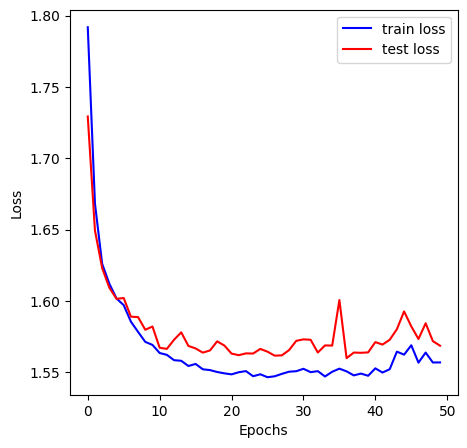

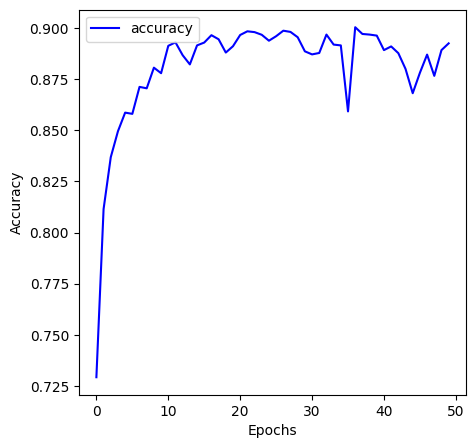

In [57]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn7")
plot_accuracy(accuracy, "nn7")

In [58]:
model7_o1 = NeuralNetwork7().to(device)
print(model7_o1)
count_parameters(model7_o1)
optimizer = torch.optim.Adam(model7_o1.parameters(), weight_decay=1e-4)
results = train_model(model7_o1, loss_fn, optimizer, 50)

NeuralNetwork7(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=10, bias=True)
    (16): Softmax(dim=None)
  )
)
651,978 total parameters.
651,978 training parameters.


100%|██████████| 469/469 [00:10<00:00, 42.91it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.824 | Test Loss: 1.726 | Accuracy: 73.4%


100%|██████████| 469/469 [00:10<00:00, 43.04it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.695 | Test Loss: 1.667 | Accuracy: 79.2%


100%|██████████| 469/469 [00:10<00:00, 43.01it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.647 | Test Loss: 1.672 | Accuracy: 78.8%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.625 | Test Loss: 1.624 | Accuracy: 83.7%


100%|██████████| 469/469 [00:10<00:00, 42.74it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.611 | Test Loss: 1.611 | Accuracy: 84.9%


100%|██████████| 469/469 [00:10<00:00, 45.82it/s]


Epoch: 06 | Time: 0m 11s | Train Loss: 1.600 | Test Loss: 1.608 | Accuracy: 85.3%


100%|██████████| 469/469 [00:11<00:00, 42.40it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.588 | Test Loss: 1.593 | Accuracy: 86.8%


100%|██████████| 469/469 [00:11<00:00, 42.26it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.581 | Test Loss: 1.589 | Accuracy: 87.2%


100%|██████████| 469/469 [00:11<00:00, 42.43it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.576 | Test Loss: 1.577 | Accuracy: 88.5%


100%|██████████| 469/469 [00:11<00:00, 42.42it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.571 | Test Loss: 1.572 | Accuracy: 88.9%


100%|██████████| 469/469 [00:11<00:00, 42.45it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.564 | Test Loss: 1.577 | Accuracy: 88.5%


100%|██████████| 469/469 [00:11<00:00, 42.47it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.563 | Test Loss: 1.578 | Accuracy: 88.3%


100%|██████████| 469/469 [00:11<00:00, 42.49it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:10<00:00, 42.85it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.557 | Test Loss: 1.571 | Accuracy: 88.9%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.554 | Test Loss: 1.570 | Accuracy: 89.1%


100%|██████████| 469/469 [00:11<00:00, 42.46it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.566 | Accuracy: 89.5%


100%|██████████| 469/469 [00:11<00:00, 42.55it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.549 | Test Loss: 1.561 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.558 | Accuracy: 90.5%


100%|██████████| 469/469 [00:11<00:00, 42.45it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.560 | Accuracy: 90.2%


100%|██████████| 469/469 [00:11<00:00, 42.52it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.542 | Test Loss: 1.565 | Accuracy: 89.6%


100%|██████████| 469/469 [00:11<00:00, 42.54it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.542 | Test Loss: 1.558 | Accuracy: 90.2%


100%|██████████| 469/469 [00:10<00:00, 42.76it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.540 | Test Loss: 1.558 | Accuracy: 90.3%


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.557 | Accuracy: 90.3%


100%|██████████| 469/469 [00:11<00:00, 42.30it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.555 | Accuracy: 90.7%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.536 | Test Loss: 1.552 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.52it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.533 | Test Loss: 1.564 | Accuracy: 89.7%


100%|██████████| 469/469 [00:11<00:00, 42.27it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.533 | Test Loss: 1.552 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.51it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.550 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 42.49it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.556 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 42.53it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.528 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.60it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 1.527 | Test Loss: 1.549 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.56it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 1.526 | Test Loss: 1.548 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.40it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 1.526 | Test Loss: 1.550 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.51it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 1.524 | Test Loss: 1.547 | Accuracy: 91.5%


100%|██████████| 469/469 [00:11<00:00, 42.60it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 1.523 | Test Loss: 1.559 | Accuracy: 90.2%


100%|██████████| 469/469 [00:11<00:00, 42.46it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 1.522 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 1.523 | Test Loss: 1.548 | Accuracy: 91.4%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 1.519 | Test Loss: 1.549 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 1.520 | Test Loss: 1.547 | Accuracy: 91.4%


100%|██████████| 469/469 [00:11<00:00, 42.53it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 1.519 | Test Loss: 1.550 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


Epoch: 41 | Time: 0m 12s | Train Loss: 1.519 | Test Loss: 1.550 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.51it/s]


Epoch: 42 | Time: 0m 12s | Train Loss: 1.518 | Test Loss: 1.546 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 42.52it/s]


Epoch: 43 | Time: 0m 12s | Train Loss: 1.518 | Test Loss: 1.546 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 42.30it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 1.517 | Test Loss: 1.545 | Accuracy: 91.8%


100%|██████████| 469/469 [00:11<00:00, 42.41it/s]


Epoch: 45 | Time: 0m 12s | Train Loss: 1.515 | Test Loss: 1.542 | Accuracy: 92.0%


100%|██████████| 469/469 [00:11<00:00, 42.50it/s]


Epoch: 46 | Time: 0m 12s | Train Loss: 1.514 | Test Loss: 1.550 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.26it/s]


Epoch: 47 | Time: 0m 12s | Train Loss: 1.513 | Test Loss: 1.543 | Accuracy: 91.8%


100%|██████████| 469/469 [00:10<00:00, 42.83it/s]


Epoch: 48 | Time: 0m 12s | Train Loss: 1.514 | Test Loss: 1.556 | Accuracy: 90.5%


100%|██████████| 469/469 [00:10<00:00, 42.75it/s]


Epoch: 49 | Time: 0m 12s | Train Loss: 1.514 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 42.53it/s]


Epoch: 50 | Time: 0m 12s | Train Loss: 1.512 | Test Loss: 1.547 | Accuracy: 91.5%


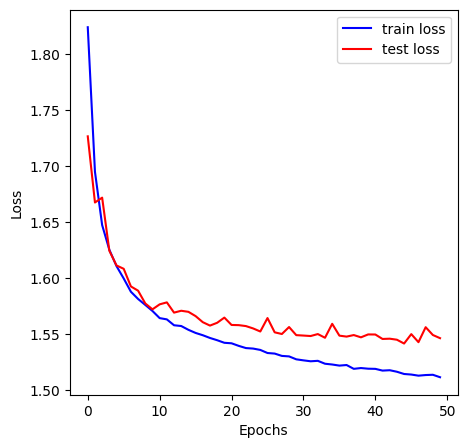

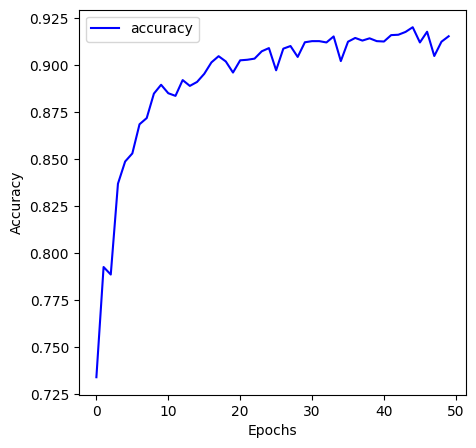

In [59]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn7-opt1")
plot_accuracy(accuracy, "nn7-opt1")

In [16]:
class NeuralNetwork8(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28 - 3 + 2 + 1 = 28
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14
            nn.Conv2d(32, 64, 3, padding=1),  # 14 - 3 + 2 + 1 = 14
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 7
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [61]:
model8 = NeuralNetwork8().to(device)
print(model8)
count_parameters(model8)
optimizer = torch.optim.Adam(model8.parameters())
results = train_model(model8, loss_fn, optimizer, 50)

NeuralNetwork8(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=10, bias=True)
    (16): Softmax(dim=None)
  )
)
3,375,882 total parameters.
3,375,882 training parameters.


100%|██████████| 469/469 [00:11<00:00, 41.34it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 1.864 | Test Loss: 1.825 | Accuracy: 63.5%


100%|██████████| 469/469 [00:10<00:00, 42.65it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.713 | Test Loss: 1.645 | Accuracy: 81.4%


100%|██████████| 469/469 [00:11<00:00, 41.42it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.626 | Test Loss: 1.618 | Accuracy: 84.2%


100%|██████████| 469/469 [00:11<00:00, 40.97it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.591 | Test Loss: 1.579 | Accuracy: 88.1%


100%|██████████| 469/469 [00:11<00:00, 41.01it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.576 | Test Loss: 1.577 | Accuracy: 88.4%


100%|██████████| 469/469 [00:12<00:00, 36.71it/s]


Epoch: 06 | Time: 0m 14s | Train Loss: 1.567 | Test Loss: 1.574 | Accuracy: 88.7%


100%|██████████| 469/469 [00:11<00:00, 39.63it/s]


Epoch: 07 | Time: 0m 13s | Train Loss: 1.560 | Test Loss: 1.566 | Accuracy: 89.4%


100%|██████████| 469/469 [00:11<00:00, 40.47it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.555 | Test Loss: 1.568 | Accuracy: 89.3%


100%|██████████| 469/469 [00:11<00:00, 40.25it/s]


Epoch: 09 | Time: 0m 13s | Train Loss: 1.554 | Test Loss: 1.556 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 40.35it/s]


Epoch: 10 | Time: 0m 13s | Train Loss: 1.549 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 40.12it/s]


Epoch: 11 | Time: 0m 13s | Train Loss: 1.545 | Test Loss: 1.553 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 41.12it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.541 | Test Loss: 1.556 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 42.08it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.541 | Test Loss: 1.561 | Accuracy: 90.0%


100%|██████████| 469/469 [00:10<00:00, 43.63it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.536 | Test Loss: 1.553 | Accuracy: 90.7%


100%|██████████| 469/469 [00:11<00:00, 42.23it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.535 | Test Loss: 1.554 | Accuracy: 90.6%


100%|██████████| 469/469 [00:11<00:00, 42.14it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.532 | Test Loss: 1.546 | Accuracy: 91.4%


100%|██████████| 469/469 [00:11<00:00, 42.15it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.534 | Test Loss: 1.553 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 42.54it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.532 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 42.10it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.553 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 42.42it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.548 | Accuracy: 91.3%


100%|██████████| 469/469 [00:11<00:00, 42.33it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.545 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 42.21it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.548 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 41.90it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.555 | Accuracy: 90.6%


100%|██████████| 469/469 [00:11<00:00, 42.38it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.529 | Test Loss: 1.552 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.03it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.529 | Test Loss: 1.547 | Accuracy: 91.3%


100%|██████████| 469/469 [00:10<00:00, 42.81it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.525 | Test Loss: 1.551 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 41.72it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.529 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 41.96it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.526 | Test Loss: 1.551 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.28it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.528 | Test Loss: 1.550 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 42.22it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.528 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 42.17it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 41.60it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 1.532 | Test Loss: 1.557 | Accuracy: 90.3%


100%|██████████| 469/469 [00:11<00:00, 42.52it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.553 | Accuracy: 90.7%


100%|██████████| 469/469 [00:11<00:00, 42.28it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 1.526 | Test Loss: 1.550 | Accuracy: 91.1%


100%|██████████| 469/469 [00:11<00:00, 42.48it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.556 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 42.16it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.559 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 42.19it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 1.532 | Test Loss: 1.557 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 42.35it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 1.530 | Test Loss: 1.553 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 42.02it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.561 | Accuracy: 89.9%


100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 1.531 | Test Loss: 1.555 | Accuracy: 90.5%


100%|██████████| 469/469 [00:11<00:00, 42.11it/s]


Epoch: 41 | Time: 0m 12s | Train Loss: 1.529 | Test Loss: 1.552 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 41.87it/s]


Epoch: 42 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.565 | Accuracy: 89.5%


100%|██████████| 469/469 [00:11<00:00, 42.17it/s]


Epoch: 43 | Time: 0m 12s | Train Loss: 1.533 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 42.05it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 1.536 | Test Loss: 1.557 | Accuracy: 90.5%


100%|██████████| 469/469 [00:11<00:00, 42.09it/s]


Epoch: 45 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.562 | Accuracy: 90.0%


100%|██████████| 469/469 [00:11<00:00, 42.27it/s]


Epoch: 46 | Time: 0m 12s | Train Loss: 1.535 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 42.29it/s]


Epoch: 47 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.567 | Accuracy: 89.3%


100%|██████████| 469/469 [00:11<00:00, 42.11it/s]


Epoch: 48 | Time: 0m 12s | Train Loss: 1.548 | Test Loss: 1.578 | Accuracy: 88.3%


100%|██████████| 469/469 [00:11<00:00, 42.57it/s]


Epoch: 49 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.557 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 42.32it/s]


Epoch: 50 | Time: 0m 12s | Train Loss: 1.543 | Test Loss: 1.578 | Accuracy: 88.3%


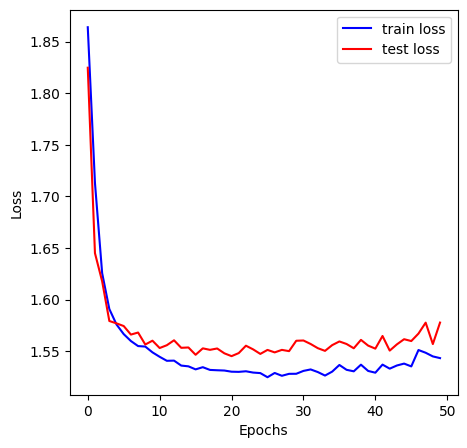

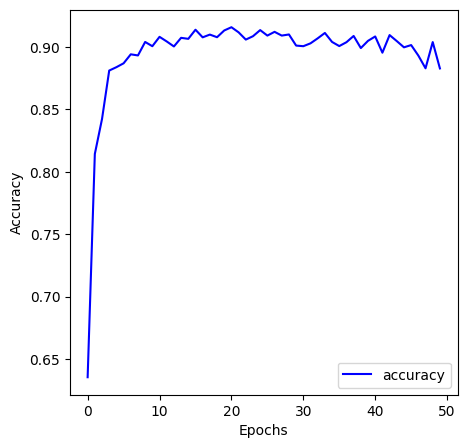

In [62]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn8")
plot_accuracy(accuracy, "nn8")

In [17]:
model8_o1 = NeuralNetwork8().to(device)
count_parameters(model8_o1)
optimizer = torch.optim.Adam(model8_o1.parameters(), lr=1e-4, weight_decay=1e-4)
results = train_model(model8_o1, loss_fn, optimizer, 35)

3,375,882 total parameters.
3,375,882 training parameters.


  0%|          | 0/469 [00:00<?, ?it/s]d:\uni\nn\lab\.venv\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 469/469 [00:11<00:00, 39.54it/s]


Epoch: 01 | Time: 0m 13s | Train Loss: 1.841 | Test Loss: 1.738 | Accuracy: 72.4%


100%|██████████| 469/469 [00:11<00:00, 41.79it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.723 | Test Loss: 1.710 | Accuracy: 75.2%


100%|██████████| 469/469 [00:11<00:00, 41.62it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.703 | Test Loss: 1.702 | Accuracy: 75.8%


100%|██████████| 469/469 [00:11<00:00, 41.64it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.694 | Test Loss: 1.689 | Accuracy: 77.1%


100%|██████████| 469/469 [00:11<00:00, 40.93it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.682 | Test Loss: 1.686 | Accuracy: 77.5%


100%|██████████| 469/469 [00:11<00:00, 41.50it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.674 | Test Loss: 1.680 | Accuracy: 78.2%


100%|██████████| 469/469 [00:11<00:00, 41.59it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.666 | Test Loss: 1.668 | Accuracy: 79.2%


100%|██████████| 469/469 [00:11<00:00, 41.26it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.663 | Test Loss: 1.668 | Accuracy: 79.1%


100%|██████████| 469/469 [00:11<00:00, 41.10it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.658 | Test Loss: 1.667 | Accuracy: 79.3%


100%|██████████| 469/469 [00:11<00:00, 41.29it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.657 | Test Loss: 1.660 | Accuracy: 80.2%


100%|██████████| 469/469 [00:11<00:00, 41.28it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.652 | Test Loss: 1.661 | Accuracy: 79.9%


100%|██████████| 469/469 [00:11<00:00, 40.95it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.649 | Test Loss: 1.657 | Accuracy: 80.7%


100%|██████████| 469/469 [00:11<00:00, 41.11it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.647 | Test Loss: 1.651 | Accuracy: 80.8%


100%|██████████| 469/469 [00:11<00:00, 40.88it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.644 | Test Loss: 1.654 | Accuracy: 80.8%


100%|██████████| 469/469 [00:11<00:00, 40.97it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.634 | Test Loss: 1.594 | Accuracy: 87.0%


100%|██████████| 469/469 [00:11<00:00, 40.64it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.583 | Test Loss: 1.583 | Accuracy: 88.0%


100%|██████████| 469/469 [00:11<00:00, 41.39it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.577 | Test Loss: 1.579 | Accuracy: 88.3%


100%|██████████| 469/469 [00:11<00:00, 41.35it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.571 | Test Loss: 1.583 | Accuracy: 87.9%


100%|██████████| 469/469 [00:11<00:00, 40.73it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.569 | Test Loss: 1.579 | Accuracy: 88.4%


100%|██████████| 469/469 [00:11<00:00, 40.84it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.566 | Test Loss: 1.572 | Accuracy: 89.1%


100%|██████████| 469/469 [00:12<00:00, 38.85it/s]


Epoch: 21 | Time: 0m 13s | Train Loss: 1.563 | Test Loss: 1.575 | Accuracy: 88.7%


100%|██████████| 469/469 [00:12<00:00, 36.97it/s]


Epoch: 22 | Time: 0m 14s | Train Loss: 1.560 | Test Loss: 1.571 | Accuracy: 89.0%


100%|██████████| 469/469 [00:10<00:00, 42.69it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.572 | Accuracy: 89.1%


100%|██████████| 469/469 [00:11<00:00, 42.16it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.556 | Test Loss: 1.570 | Accuracy: 89.2%


100%|██████████| 469/469 [00:11<00:00, 41.82it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.554 | Test Loss: 1.565 | Accuracy: 89.8%


100%|██████████| 469/469 [00:11<00:00, 40.92it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.565 | Accuracy: 89.8%


100%|██████████| 469/469 [00:11<00:00, 39.73it/s]


Epoch: 27 | Time: 0m 13s | Train Loss: 1.550 | Test Loss: 1.563 | Accuracy: 89.8%


100%|██████████| 469/469 [00:11<00:00, 40.57it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.548 | Test Loss: 1.562 | Accuracy: 90.0%


100%|██████████| 469/469 [00:11<00:00, 39.93it/s]


Epoch: 29 | Time: 0m 13s | Train Loss: 1.548 | Test Loss: 1.560 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 41.03it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.560 | Accuracy: 90.2%


100%|██████████| 469/469 [00:11<00:00, 41.19it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 1.544 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 41.46it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 1.542 | Test Loss: 1.558 | Accuracy: 90.5%


100%|██████████| 469/469 [00:11<00:00, 41.15it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 1.541 | Test Loss: 1.560 | Accuracy: 90.3%


100%|██████████| 469/469 [00:11<00:00, 41.33it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 1.539 | Test Loss: 1.555 | Accuracy: 90.7%


100%|██████████| 469/469 [00:11<00:00, 41.46it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.570 | Accuracy: 89.2%


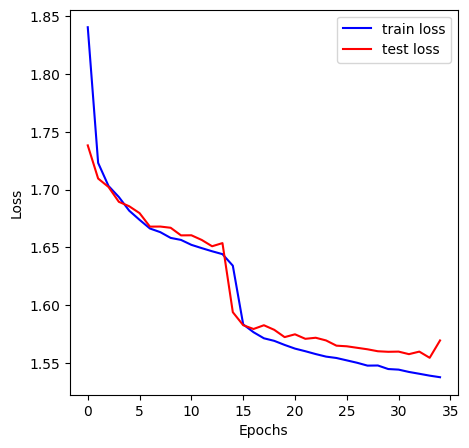

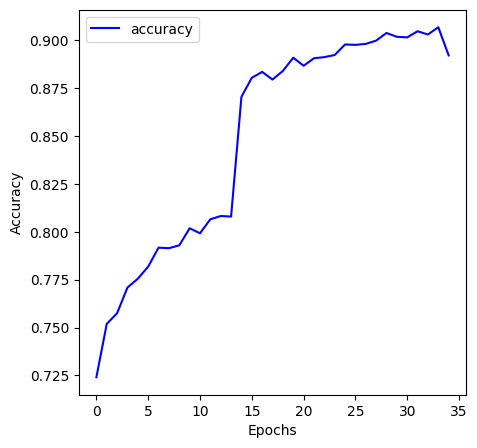

In [18]:
train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn8-opt1")
plot_accuracy(accuracy, "nn8-opt1")

NeuralNetwork9(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): AdaptiveAvgPool2d(output_size=(1, 1))
    (15): Flatten(s

100%|██████████| 469/469 [00:11<00:00, 39.89it/s]


Epoch: 01 | Time: 0m 13s | Train Loss: 1.769 | Test Loss: 1.728 | Accuracy: 73.9%


100%|██████████| 469/469 [00:11<00:00, 42.37it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.662 | Test Loss: 1.674 | Accuracy: 78.6%


100%|██████████| 469/469 [00:11<00:00, 42.33it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.626 | Test Loss: 1.689 | Accuracy: 77.3%


100%|██████████| 469/469 [00:11<00:00, 42.40it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.602 | Test Loss: 1.599 | Accuracy: 86.3%


100%|██████████| 469/469 [00:11<00:00, 42.63it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.590 | Test Loss: 1.597 | Accuracy: 86.6%


100%|██████████| 469/469 [00:11<00:00, 42.24it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.583 | Test Loss: 1.626 | Accuracy: 83.5%


100%|██████████| 469/469 [00:11<00:00, 42.36it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.578 | Test Loss: 1.579 | Accuracy: 88.3%


100%|██████████| 469/469 [00:11<00:00, 42.31it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.572 | Test Loss: 1.603 | Accuracy: 86.0%


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.569 | Test Loss: 1.620 | Accuracy: 84.1%


100%|██████████| 469/469 [00:11<00:00, 42.05it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.567 | Test Loss: 1.569 | Accuracy: 89.2%


100%|██████████| 469/469 [00:11<00:00, 42.40it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.561 | Test Loss: 1.571 | Accuracy: 89.0%


100%|██████████| 469/469 [00:11<00:00, 42.34it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.560 | Test Loss: 1.586 | Accuracy: 87.4%


100%|██████████| 469/469 [00:11<00:00, 42.22it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.587 | Accuracy: 87.4%


100%|██████████| 469/469 [00:11<00:00, 42.32it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.555 | Test Loss: 1.568 | Accuracy: 89.4%


100%|██████████| 469/469 [00:11<00:00, 42.42it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.561 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 42.34it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.599 | Accuracy: 86.3%


100%|██████████| 469/469 [00:11<00:00, 42.31it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.562 | Accuracy: 90.0%


100%|██████████| 469/469 [00:11<00:00, 40.80it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.556 | Accuracy: 90.4%


100%|██████████| 469/469 [00:11<00:00, 41.57it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.604 | Accuracy: 85.5%


100%|██████████| 469/469 [00:11<00:00, 42.25it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.591 | Accuracy: 86.9%


100%|██████████| 469/469 [00:11<00:00, 41.64it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.547 | Test Loss: 1.568 | Accuracy: 89.1%


100%|██████████| 469/469 [00:11<00:00, 42.00it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.546 | Test Loss: 1.563 | Accuracy: 89.8%


100%|██████████| 469/469 [00:11<00:00, 41.96it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.566 | Accuracy: 89.5%


100%|██████████| 469/469 [00:11<00:00, 42.12it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.543 | Test Loss: 1.567 | Accuracy: 89.5%


100%|██████████| 469/469 [00:11<00:00, 41.91it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.539 | Test Loss: 1.550 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 41.81it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.541 | Test Loss: 1.565 | Accuracy: 89.7%


100%|██████████| 469/469 [00:11<00:00, 41.89it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.540 | Test Loss: 1.580 | Accuracy: 88.1%


100%|██████████| 469/469 [00:11<00:00, 41.71it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.539 | Test Loss: 1.558 | Accuracy: 90.2%


100%|██████████| 469/469 [00:11<00:00, 41.94it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.537 | Test Loss: 1.570 | Accuracy: 89.1%


100%|██████████| 469/469 [00:11<00:00, 41.99it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.562 | Accuracy: 89.9%


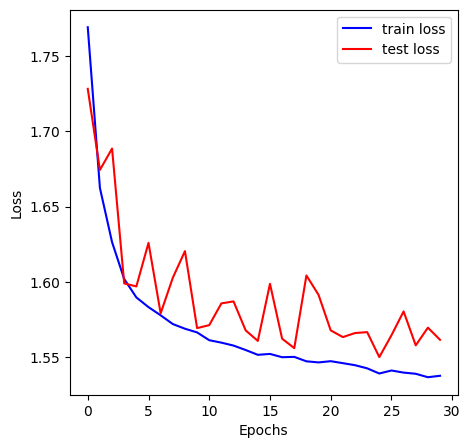

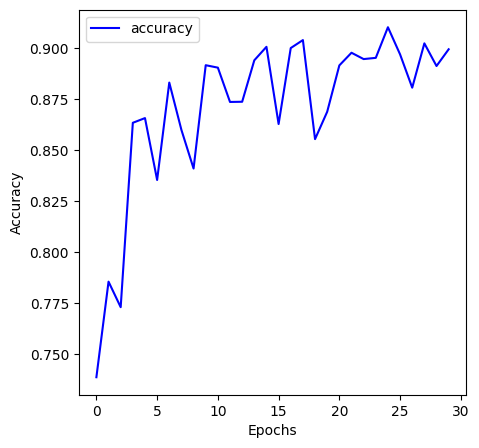

In [65]:
class NeuralNetwork9(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28 - 3 + 2 + 1 = 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14
            nn.Conv2d(32, 64, 3, padding=1),  # 14 - 3 + 2 + 1 = 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 7
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits


model9 = NeuralNetwork9().to(device)
print(model9)
count_parameters(model9)
optimizer = torch.optim.Adam(model9.parameters())
results = train_model(model9, loss_fn, optimizer, 30)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn9")
plot_accuracy(accuracy, "nn9")

NeuralNetwork9(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): AdaptiveAvgPool2d(output_size=(1, 1))
    (15): Flatten(s

100%|██████████| 469/469 [00:11<00:00, 41.77it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 2.084 | Test Loss: 1.862 | Accuracy: 69.0%


100%|██████████| 469/469 [00:11<00:00, 42.33it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.777 | Test Loss: 1.714 | Accuracy: 76.6%


100%|██████████| 469/469 [00:11<00:00, 42.30it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.694 | Test Loss: 1.668 | Accuracy: 80.7%


100%|██████████| 469/469 [00:11<00:00, 42.19it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.661 | Test Loss: 1.645 | Accuracy: 82.4%


100%|██████████| 469/469 [00:11<00:00, 42.38it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.642 | Test Loss: 1.634 | Accuracy: 83.6%


100%|██████████| 469/469 [00:11<00:00, 42.15it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.628 | Test Loss: 1.642 | Accuracy: 82.3%


100%|██████████| 469/469 [00:11<00:00, 42.34it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.617 | Test Loss: 1.611 | Accuracy: 85.5%


100%|██████████| 469/469 [00:11<00:00, 42.23it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.609 | Test Loss: 1.606 | Accuracy: 86.2%


100%|██████████| 469/469 [00:11<00:00, 42.28it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.602 | Test Loss: 1.624 | Accuracy: 84.4%


100%|██████████| 469/469 [00:11<00:00, 41.71it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.595 | Test Loss: 1.616 | Accuracy: 84.9%


100%|██████████| 469/469 [00:11<00:00, 42.05it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.592 | Test Loss: 1.608 | Accuracy: 85.8%


100%|██████████| 469/469 [00:11<00:00, 41.93it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.586 | Test Loss: 1.589 | Accuracy: 87.5%


100%|██████████| 469/469 [00:11<00:00, 41.93it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.584 | Test Loss: 1.617 | Accuracy: 84.8%


100%|██████████| 469/469 [00:11<00:00, 42.00it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.579 | Test Loss: 1.607 | Accuracy: 86.0%


100%|██████████| 469/469 [00:11<00:00, 41.87it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.576 | Test Loss: 1.593 | Accuracy: 87.5%


100%|██████████| 469/469 [00:11<00:00, 42.06it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.573 | Test Loss: 1.586 | Accuracy: 87.9%


100%|██████████| 469/469 [00:11<00:00, 41.89it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.570 | Test Loss: 1.581 | Accuracy: 88.4%


100%|██████████| 469/469 [00:11<00:00, 41.81it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.570 | Test Loss: 1.581 | Accuracy: 88.4%


100%|██████████| 469/469 [00:11<00:00, 42.16it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.566 | Test Loss: 1.598 | Accuracy: 86.7%


100%|██████████| 469/469 [00:11<00:00, 42.01it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.563 | Test Loss: 1.582 | Accuracy: 88.4%


100%|██████████| 469/469 [00:11<00:00, 41.77it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.561 | Test Loss: 1.578 | Accuracy: 88.5%


100%|██████████| 469/469 [00:11<00:00, 42.02it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.559 | Test Loss: 1.580 | Accuracy: 88.5%


100%|██████████| 469/469 [00:11<00:00, 41.88it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.558 | Test Loss: 1.625 | Accuracy: 83.8%


100%|██████████| 469/469 [00:11<00:00, 41.78it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.556 | Test Loss: 1.574 | Accuracy: 89.0%


100%|██████████| 469/469 [00:11<00:00, 41.99it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.555 | Test Loss: 1.582 | Accuracy: 88.2%


100%|██████████| 469/469 [00:11<00:00, 41.96it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.552 | Test Loss: 1.586 | Accuracy: 87.8%


100%|██████████| 469/469 [00:11<00:00, 42.03it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.551 | Test Loss: 1.567 | Accuracy: 89.7%


100%|██████████| 469/469 [00:11<00:00, 41.85it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.550 | Test Loss: 1.568 | Accuracy: 89.5%


100%|██████████| 469/469 [00:11<00:00, 42.08it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.548 | Test Loss: 1.564 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 41.90it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.546 | Test Loss: 1.576 | Accuracy: 88.9%


100%|██████████| 469/469 [00:11<00:00, 42.13it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 1.545 | Test Loss: 1.584 | Accuracy: 88.0%


100%|██████████| 469/469 [00:11<00:00, 41.86it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 1.544 | Test Loss: 1.592 | Accuracy: 87.2%


100%|██████████| 469/469 [00:11<00:00, 41.66it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 1.543 | Test Loss: 1.565 | Accuracy: 89.8%


100%|██████████| 469/469 [00:11<00:00, 41.78it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 1.541 | Test Loss: 1.570 | Accuracy: 89.2%


100%|██████████| 469/469 [00:11<00:00, 41.59it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 1.539 | Test Loss: 1.561 | Accuracy: 90.2%


100%|██████████| 469/469 [00:11<00:00, 41.35it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.569 | Accuracy: 89.3%


100%|██████████| 469/469 [00:11<00:00, 41.82it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 1.538 | Test Loss: 1.570 | Accuracy: 89.4%


100%|██████████| 469/469 [00:11<00:00, 42.11it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 1.536 | Test Loss: 1.562 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 41.64it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 1.536 | Test Loss: 1.574 | Accuracy: 89.0%


100%|██████████| 469/469 [00:11<00:00, 41.74it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 1.534 | Test Loss: 1.565 | Accuracy: 89.9%


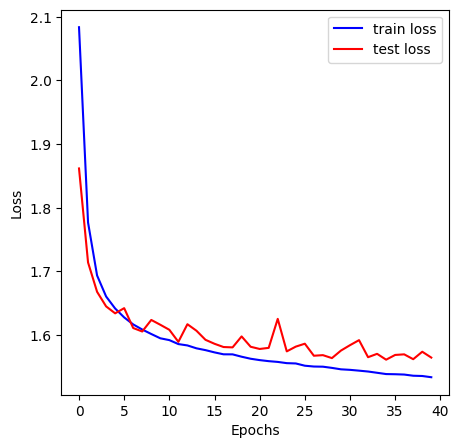

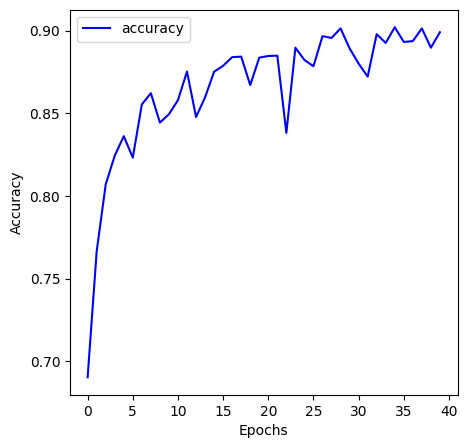

In [66]:
model9_o1 = NeuralNetwork9().to(device)
print(model9_o1)
count_parameters(model9_o1)
optimizer = torch.optim.Adam(
    model9_o1.parameters(), lr=1e-4, betas=(0.95, 0.99), weight_decay=1e-4
)
results = train_model(model9_o1, loss_fn, optimizer, 40)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn9-opt1")
plot_accuracy(accuracy, "nn9-opt1")

NeuralNetwork10(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=2048, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=2048, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=256, out_features=64, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.1, inplace=False)
    (19): Linear(in_features=64,

100%|██████████| 469/469 [00:11<00:00, 39.82it/s]


Epoch: 01 | Time: 0m 13s | Train Loss: 1.835 | Test Loss: 1.799 | Accuracy: 66.1%


100%|██████████| 469/469 [00:11<00:00, 40.49it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.829 | Test Loss: 1.857 | Accuracy: 60.4%


100%|██████████| 469/469 [00:11<00:00, 40.65it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.843 | Test Loss: 1.938 | Accuracy: 52.2%


100%|██████████| 469/469 [00:11<00:00, 40.63it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 2.043 | Test Loss: 2.086 | Accuracy: 37.4%


100%|██████████| 469/469 [00:11<00:00, 39.85it/s]


Epoch: 05 | Time: 0m 13s | Train Loss: 2.005 | Test Loss: 2.129 | Accuracy: 33.1%


100%|██████████| 469/469 [00:11<00:00, 39.87it/s]


Epoch: 06 | Time: 0m 13s | Train Loss: 2.084 | Test Loss: 2.104 | Accuracy: 35.5%


100%|██████████| 469/469 [00:11<00:00, 39.74it/s]


Epoch: 07 | Time: 0m 13s | Train Loss: 2.065 | Test Loss: 2.039 | Accuracy: 42.0%


100%|██████████| 469/469 [00:11<00:00, 40.52it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 2.085 | Test Loss: 2.146 | Accuracy: 31.4%


100%|██████████| 469/469 [00:11<00:00, 40.45it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 2.093 | Test Loss: 2.091 | Accuracy: 36.8%


100%|██████████| 469/469 [00:11<00:00, 40.59it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 2.116 | Test Loss: 2.085 | Accuracy: 37.6%


100%|██████████| 469/469 [00:11<00:00, 40.55it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 2.039 | Test Loss: 2.048 | Accuracy: 41.2%


100%|██████████| 469/469 [00:11<00:00, 40.48it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 2.065 | Test Loss: 2.120 | Accuracy: 33.9%


100%|██████████| 469/469 [00:11<00:00, 40.53it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 2.096 | Test Loss: 2.064 | Accuracy: 39.6%


100%|██████████| 469/469 [00:11<00:00, 40.51it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 2.072 | Test Loss: 2.092 | Accuracy: 36.9%


100%|██████████| 469/469 [00:11<00:00, 40.39it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 2.101 | Test Loss: 2.155 | Accuracy: 30.5%


100%|██████████| 469/469 [00:11<00:00, 40.58it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 2.127 | Test Loss: 2.101 | Accuracy: 36.0%


100%|██████████| 469/469 [00:11<00:00, 40.51it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 2.091 | Test Loss: 2.094 | Accuracy: 36.7%


100%|██████████| 469/469 [00:11<00:00, 40.47it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 2.104 | Test Loss: 2.145 | Accuracy: 31.6%


100%|██████████| 469/469 [00:11<00:00, 40.44it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 2.103 | Test Loss: 2.098 | Accuracy: 36.4%


100%|██████████| 469/469 [00:11<00:00, 40.61it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 2.164 | Test Loss: 2.175 | Accuracy: 28.6%


100%|██████████| 469/469 [00:11<00:00, 40.56it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 2.251 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.56it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.59it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.59it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.45it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.57it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.41it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.56it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.63it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 2.358 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.65it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.44it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.64it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.61it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.41it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.61it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.57it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch: 41 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.41it/s]


Epoch: 42 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch: 43 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch: 45 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.68it/s]


Epoch: 46 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.69it/s]


Epoch: 47 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.60it/s]


Epoch: 48 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.65it/s]


Epoch: 49 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Epoch: 50 | Time: 0m 12s | Train Loss: 2.361 | Test Loss: 2.362 | Accuracy: 10.0%


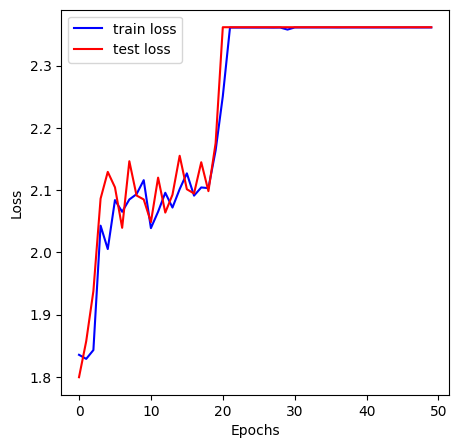

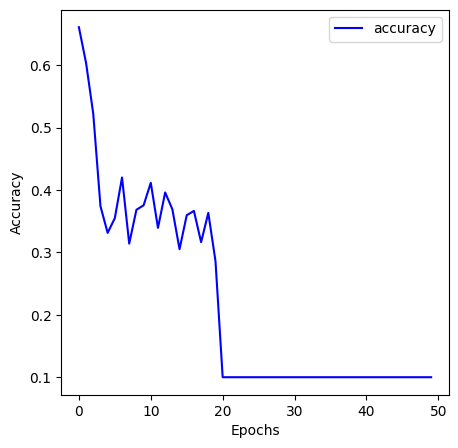

In [67]:
class NeuralNetwork10(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14
            nn.Flatten(),
            nn.Linear(32 * 14 * 14, 2048),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits


model10 = NeuralNetwork10().to(device)
print(model10)
count_parameters(model10)
optimizer = torch.optim.Adam(model10.parameters())
results = train_model(model10, loss_fn, optimizer, 50)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn10")
plot_accuracy(accuracy, "nn10")

NeuralNetwork10(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=2048, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=2048, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=256, out_features=64, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.1, inplace=False)
    (19): Linear(in_features=64,

100%|██████████| 469/469 [00:12<00:00, 37.53it/s]


Epoch: 01 | Time: 0m 13s | Train Loss: 1.715 | Test Loss: 1.613 | Accuracy: 85.1%


100%|██████████| 469/469 [00:12<00:00, 38.40it/s]


Epoch: 02 | Time: 0m 13s | Train Loss: 1.599 | Test Loss: 1.595 | Accuracy: 86.7%


100%|██████████| 469/469 [00:12<00:00, 38.41it/s]


Epoch: 03 | Time: 0m 13s | Train Loss: 1.582 | Test Loss: 1.592 | Accuracy: 87.0%


100%|██████████| 469/469 [00:12<00:00, 39.02it/s]


Epoch: 04 | Time: 0m 13s | Train Loss: 1.572 | Test Loss: 1.577 | Accuracy: 88.4%


100%|██████████| 469/469 [00:11<00:00, 39.34it/s]


Epoch: 05 | Time: 0m 13s | Train Loss: 1.564 | Test Loss: 1.580 | Accuracy: 88.0%


100%|██████████| 469/469 [00:12<00:00, 38.94it/s]


Epoch: 06 | Time: 0m 13s | Train Loss: 1.561 | Test Loss: 1.572 | Accuracy: 88.9%


100%|██████████| 469/469 [00:12<00:00, 38.58it/s]


Epoch: 07 | Time: 0m 13s | Train Loss: 1.558 | Test Loss: 1.579 | Accuracy: 88.3%


100%|██████████| 469/469 [00:12<00:00, 38.86it/s]


Epoch: 08 | Time: 0m 13s | Train Loss: 1.551 | Test Loss: 1.563 | Accuracy: 90.0%


100%|██████████| 469/469 [00:12<00:00, 38.63it/s]


Epoch: 09 | Time: 0m 13s | Train Loss: 1.549 | Test Loss: 1.568 | Accuracy: 89.3%


100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Epoch: 10 | Time: 0m 13s | Train Loss: 1.547 | Test Loss: 1.566 | Accuracy: 89.5%


100%|██████████| 469/469 [00:12<00:00, 38.53it/s]


Epoch: 11 | Time: 0m 13s | Train Loss: 1.542 | Test Loss: 1.565 | Accuracy: 89.7%


100%|██████████| 469/469 [00:12<00:00, 38.97it/s]


Epoch: 12 | Time: 0m 13s | Train Loss: 1.542 | Test Loss: 1.560 | Accuracy: 90.1%


100%|██████████| 469/469 [00:11<00:00, 39.09it/s]


Epoch: 13 | Time: 0m 13s | Train Loss: 1.540 | Test Loss: 1.557 | Accuracy: 90.4%


100%|██████████| 469/469 [00:12<00:00, 39.08it/s]


Epoch: 14 | Time: 0m 13s | Train Loss: 1.536 | Test Loss: 1.556 | Accuracy: 90.7%


100%|██████████| 469/469 [00:11<00:00, 39.17it/s]


Epoch: 15 | Time: 0m 13s | Train Loss: 1.532 | Test Loss: 1.554 | Accuracy: 90.8%


100%|██████████| 469/469 [00:12<00:00, 39.04it/s]


Epoch: 16 | Time: 0m 13s | Train Loss: 1.531 | Test Loss: 1.555 | Accuracy: 90.6%


100%|██████████| 469/469 [00:11<00:00, 39.15it/s]


Epoch: 17 | Time: 0m 13s | Train Loss: 1.528 | Test Loss: 1.551 | Accuracy: 91.1%


100%|██████████| 469/469 [00:12<00:00, 38.74it/s]


Epoch: 18 | Time: 0m 13s | Train Loss: 1.526 | Test Loss: 1.563 | Accuracy: 89.7%


100%|██████████| 469/469 [00:12<00:00, 39.07it/s]


Epoch: 19 | Time: 0m 13s | Train Loss: 1.525 | Test Loss: 1.550 | Accuracy: 91.1%


100%|██████████| 469/469 [00:12<00:00, 38.73it/s]


Epoch: 20 | Time: 0m 13s | Train Loss: 1.521 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:12<00:00, 38.60it/s]


Epoch: 21 | Time: 0m 13s | Train Loss: 1.521 | Test Loss: 1.561 | Accuracy: 90.0%


100%|██████████| 469/469 [00:12<00:00, 39.06it/s]


Epoch: 22 | Time: 0m 13s | Train Loss: 1.523 | Test Loss: 1.550 | Accuracy: 91.1%


100%|██████████| 469/469 [00:11<00:00, 39.23it/s]


Epoch: 23 | Time: 0m 13s | Train Loss: 1.519 | Test Loss: 1.552 | Accuracy: 90.9%


100%|██████████| 469/469 [00:12<00:00, 38.93it/s]


Epoch: 24 | Time: 0m 13s | Train Loss: 1.516 | Test Loss: 1.553 | Accuracy: 90.8%


100%|██████████| 469/469 [00:11<00:00, 39.22it/s]


Epoch: 25 | Time: 0m 13s | Train Loss: 1.516 | Test Loss: 1.549 | Accuracy: 91.2%


100%|██████████| 469/469 [00:11<00:00, 39.22it/s]


Epoch: 26 | Time: 0m 13s | Train Loss: 1.515 | Test Loss: 1.550 | Accuracy: 91.1%


100%|██████████| 469/469 [00:11<00:00, 39.23it/s]


Epoch: 27 | Time: 0m 13s | Train Loss: 1.513 | Test Loss: 1.545 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 39.20it/s]


Epoch: 28 | Time: 0m 13s | Train Loss: 1.512 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:11<00:00, 39.19it/s]


Epoch: 29 | Time: 0m 13s | Train Loss: 1.510 | Test Loss: 1.543 | Accuracy: 91.9%


100%|██████████| 469/469 [00:11<00:00, 39.23it/s]


Epoch: 30 | Time: 0m 13s | Train Loss: 1.510 | Test Loss: 1.546 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 39.28it/s]


Epoch: 31 | Time: 0m 13s | Train Loss: 1.509 | Test Loss: 1.544 | Accuracy: 91.8%


100%|██████████| 469/469 [00:12<00:00, 38.75it/s]


Epoch: 32 | Time: 0m 13s | Train Loss: 1.509 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:12<00:00, 38.82it/s]


Epoch: 33 | Time: 0m 13s | Train Loss: 1.508 | Test Loss: 1.553 | Accuracy: 90.9%


100%|██████████| 469/469 [00:11<00:00, 39.53it/s]


Epoch: 34 | Time: 0m 13s | Train Loss: 1.505 | Test Loss: 1.556 | Accuracy: 90.6%


100%|██████████| 469/469 [00:11<00:00, 39.46it/s]


Epoch: 35 | Time: 0m 13s | Train Loss: 1.506 | Test Loss: 1.544 | Accuracy: 91.6%


100%|██████████| 469/469 [00:11<00:00, 39.49it/s]


Epoch: 36 | Time: 0m 13s | Train Loss: 1.504 | Test Loss: 1.545 | Accuracy: 91.6%


100%|██████████| 469/469 [00:12<00:00, 38.63it/s]


Epoch: 37 | Time: 0m 13s | Train Loss: 1.502 | Test Loss: 1.550 | Accuracy: 91.2%


100%|██████████| 469/469 [00:12<00:00, 38.58it/s]


Epoch: 38 | Time: 0m 13s | Train Loss: 1.501 | Test Loss: 1.543 | Accuracy: 91.8%


100%|██████████| 469/469 [00:11<00:00, 39.15it/s]


Epoch: 39 | Time: 0m 13s | Train Loss: 1.504 | Test Loss: 1.551 | Accuracy: 91.0%


100%|██████████| 469/469 [00:12<00:00, 39.06it/s]


Epoch: 40 | Time: 0m 13s | Train Loss: 1.503 | Test Loss: 1.544 | Accuracy: 91.6%


100%|██████████| 469/469 [00:12<00:00, 39.03it/s]


Epoch: 41 | Time: 0m 13s | Train Loss: 1.500 | Test Loss: 1.544 | Accuracy: 91.9%


100%|██████████| 469/469 [00:12<00:00, 38.99it/s]


Epoch: 42 | Time: 0m 13s | Train Loss: 1.499 | Test Loss: 1.539 | Accuracy: 92.3%


100%|██████████| 469/469 [00:11<00:00, 39.10it/s]


Epoch: 43 | Time: 0m 13s | Train Loss: 1.498 | Test Loss: 1.540 | Accuracy: 92.2%


100%|██████████| 469/469 [00:12<00:00, 39.05it/s]


Epoch: 44 | Time: 0m 13s | Train Loss: 1.498 | Test Loss: 1.540 | Accuracy: 92.2%


100%|██████████| 469/469 [00:11<00:00, 39.25it/s]


Epoch: 45 | Time: 0m 13s | Train Loss: 1.497 | Test Loss: 1.543 | Accuracy: 91.9%


100%|██████████| 469/469 [00:11<00:00, 39.21it/s]


Epoch: 46 | Time: 0m 13s | Train Loss: 1.497 | Test Loss: 1.543 | Accuracy: 91.8%


100%|██████████| 469/469 [00:11<00:00, 39.16it/s]


Epoch: 47 | Time: 0m 13s | Train Loss: 1.495 | Test Loss: 1.541 | Accuracy: 92.0%


100%|██████████| 469/469 [00:12<00:00, 38.72it/s]


Epoch: 48 | Time: 0m 13s | Train Loss: 1.496 | Test Loss: 1.539 | Accuracy: 92.2%


100%|██████████| 469/469 [00:12<00:00, 38.45it/s]


Epoch: 49 | Time: 0m 13s | Train Loss: 1.494 | Test Loss: 1.541 | Accuracy: 92.1%


100%|██████████| 469/469 [00:12<00:00, 38.67it/s]


Epoch: 50 | Time: 0m 13s | Train Loss: 1.494 | Test Loss: 1.545 | Accuracy: 91.7%


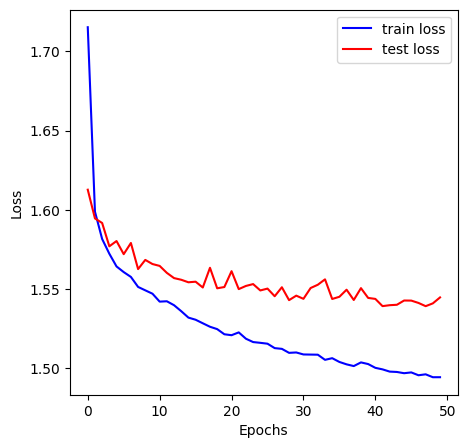

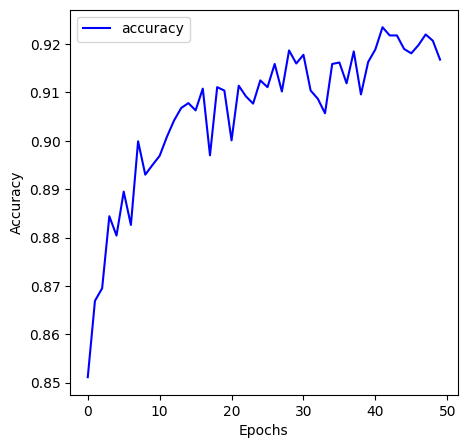

In [68]:
model10_o1 = NeuralNetwork10().to(device)
print(model10_o1)
count_parameters(model10_o1)
optimizer = torch.optim.Adam(model10_o1.parameters(), lr=1e-4, betas=(0.95, 0.99), weight_decay=1e-4)
results = train_model(model10_o1, loss_fn, optimizer, 50)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn10-opt1")
plot_accuracy(accuracy, "nn10-opt1")

NeuralNetwork11(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): AdaptiveAvgPool2d(output_size=(1, 1))
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=32, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
    (13): Softmax(dim=None)
  )
)
10,410 total parameters.
10,410 training parameters.


100%|██████████| 469/469 [00:10<00:00, 44.99it/s]


Epoch: 01 | Time: 0m 11s | Train Loss: 1.983 | Test Loss: 1.849 | Accuracy: 64.0%


100%|██████████| 469/469 [00:10<00:00, 43.31it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 1.821 | Test Loss: 1.781 | Accuracy: 70.7%


100%|██████████| 469/469 [00:10<00:00, 43.33it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 1.770 | Test Loss: 1.750 | Accuracy: 72.9%


100%|██████████| 469/469 [00:10<00:00, 43.19it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 1.740 | Test Loss: 1.720 | Accuracy: 75.3%


100%|██████████| 469/469 [00:10<00:00, 43.13it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 1.724 | Test Loss: 1.740 | Accuracy: 73.0%


100%|██████████| 469/469 [00:10<00:00, 42.79it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 1.710 | Test Loss: 1.743 | Accuracy: 72.7%


100%|██████████| 469/469 [00:10<00:00, 43.32it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 1.699 | Test Loss: 1.694 | Accuracy: 77.8%


100%|██████████| 469/469 [00:10<00:00, 43.55it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 1.690 | Test Loss: 1.708 | Accuracy: 75.8%


100%|██████████| 469/469 [00:10<00:00, 43.27it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 1.681 | Test Loss: 1.707 | Accuracy: 75.9%


100%|██████████| 469/469 [00:10<00:00, 43.18it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 1.675 | Test Loss: 1.679 | Accuracy: 79.3%


100%|██████████| 469/469 [00:10<00:00, 43.36it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 1.668 | Test Loss: 1.708 | Accuracy: 76.1%


100%|██████████| 469/469 [00:10<00:00, 42.97it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 1.666 | Test Loss: 1.710 | Accuracy: 75.4%


100%|██████████| 469/469 [00:10<00:00, 43.34it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 1.660 | Test Loss: 1.686 | Accuracy: 77.9%


100%|██████████| 469/469 [00:10<00:00, 43.23it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 1.655 | Test Loss: 1.687 | Accuracy: 78.0%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 1.653 | Test Loss: 1.660 | Accuracy: 80.8%


100%|██████████| 469/469 [00:10<00:00, 43.03it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 1.651 | Test Loss: 1.654 | Accuracy: 81.2%


100%|██████████| 469/469 [00:10<00:00, 43.32it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 1.644 | Test Loss: 1.696 | Accuracy: 76.9%


100%|██████████| 469/469 [00:10<00:00, 43.27it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 1.643 | Test Loss: 1.650 | Accuracy: 81.5%


100%|██████████| 469/469 [00:10<00:00, 43.25it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 1.640 | Test Loss: 1.660 | Accuracy: 80.6%


100%|██████████| 469/469 [00:10<00:00, 43.14it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 1.640 | Test Loss: 1.669 | Accuracy: 79.5%


100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 1.636 | Test Loss: 1.639 | Accuracy: 82.9%


100%|██████████| 469/469 [00:10<00:00, 43.17it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 1.635 | Test Loss: 1.703 | Accuracy: 75.7%


100%|██████████| 469/469 [00:10<00:00, 43.20it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 1.633 | Test Loss: 1.628 | Accuracy: 83.8%


100%|██████████| 469/469 [00:10<00:00, 43.12it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 1.629 | Test Loss: 1.650 | Accuracy: 81.4%


100%|██████████| 469/469 [00:10<00:00, 43.11it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 1.627 | Test Loss: 1.663 | Accuracy: 80.0%


100%|██████████| 469/469 [00:10<00:00, 43.03it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 1.626 | Test Loss: 1.632 | Accuracy: 83.3%


100%|██████████| 469/469 [00:10<00:00, 43.23it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 1.627 | Test Loss: 1.635 | Accuracy: 83.0%


100%|██████████| 469/469 [00:10<00:00, 43.19it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 1.625 | Test Loss: 1.679 | Accuracy: 78.5%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 1.622 | Test Loss: 1.625 | Accuracy: 84.0%


100%|██████████| 469/469 [00:10<00:00, 43.34it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 1.622 | Test Loss: 1.631 | Accuracy: 83.5%


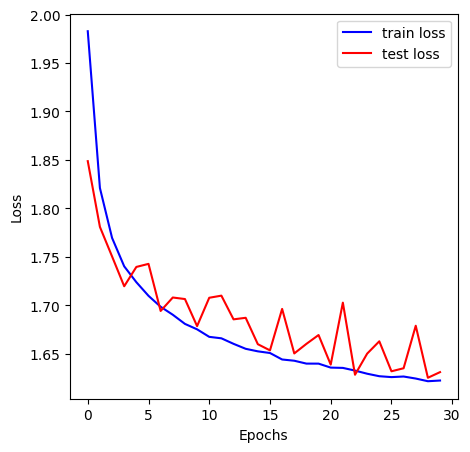

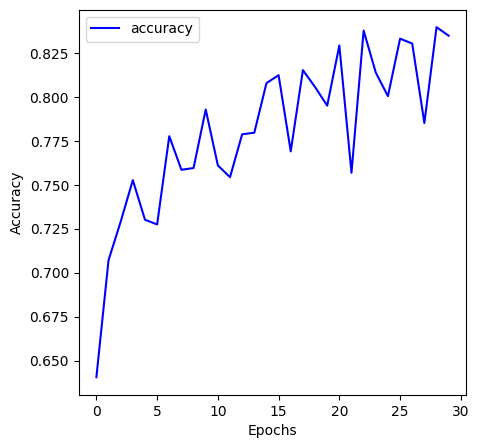

In [69]:
class NeuralNetwork11(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits


model11 = NeuralNetwork11().to(device)
print(model11)
count_parameters(model11)
optimizer = torch.optim.Adam(model11.parameters())
results = train_model(model11, loss_fn, optimizer, 30)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn11")
plot_accuracy(accuracy, "nn11")

NeuralNetwork11(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): AdaptiveAvgPool2d(output_size=(1, 1))
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=32, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
    (13): Softmax(dim=None)
  )
)
10,410 total parameters.
10,410 training parameters.


100%|██████████| 469/469 [00:10<00:00, 43.39it/s]


Epoch: 01 | Time: 0m 12s | Train Loss: 2.301 | Test Loss: 2.298 | Accuracy: 10.0%


100%|██████████| 469/469 [00:10<00:00, 43.31it/s]


Epoch: 02 | Time: 0m 12s | Train Loss: 2.296 | Test Loss: 2.294 | Accuracy: 12.6%


100%|██████████| 469/469 [00:10<00:00, 43.44it/s]


Epoch: 03 | Time: 0m 12s | Train Loss: 2.292 | Test Loss: 2.289 | Accuracy: 16.6%


100%|██████████| 469/469 [00:10<00:00, 43.42it/s]


Epoch: 04 | Time: 0m 12s | Train Loss: 2.287 | Test Loss: 2.284 | Accuracy: 18.4%


100%|██████████| 469/469 [00:10<00:00, 43.27it/s]


Epoch: 05 | Time: 0m 12s | Train Loss: 2.280 | Test Loss: 2.276 | Accuracy: 19.4%


100%|██████████| 469/469 [00:10<00:00, 43.29it/s]


Epoch: 06 | Time: 0m 12s | Train Loss: 2.271 | Test Loss: 2.266 | Accuracy: 19.4%


100%|██████████| 469/469 [00:10<00:00, 43.41it/s]


Epoch: 07 | Time: 0m 12s | Train Loss: 2.261 | Test Loss: 2.255 | Accuracy: 19.5%


100%|██████████| 469/469 [00:10<00:00, 43.25it/s]


Epoch: 08 | Time: 0m 12s | Train Loss: 2.249 | Test Loss: 2.242 | Accuracy: 19.4%


100%|██████████| 469/469 [00:10<00:00, 43.36it/s]


Epoch: 09 | Time: 0m 12s | Train Loss: 2.237 | Test Loss: 2.230 | Accuracy: 19.9%


100%|██████████| 469/469 [00:10<00:00, 43.34it/s]


Epoch: 10 | Time: 0m 12s | Train Loss: 2.227 | Test Loss: 2.219 | Accuracy: 22.2%


100%|██████████| 469/469 [00:10<00:00, 43.26it/s]


Epoch: 11 | Time: 0m 12s | Train Loss: 2.216 | Test Loss: 2.209 | Accuracy: 26.4%


100%|██████████| 469/469 [00:10<00:00, 43.24it/s]


Epoch: 12 | Time: 0m 12s | Train Loss: 2.207 | Test Loss: 2.199 | Accuracy: 29.1%


100%|██████████| 469/469 [00:10<00:00, 43.29it/s]


Epoch: 13 | Time: 0m 12s | Train Loss: 2.197 | Test Loss: 2.189 | Accuracy: 30.8%


100%|██████████| 469/469 [00:10<00:00, 43.18it/s]


Epoch: 14 | Time: 0m 12s | Train Loss: 2.186 | Test Loss: 2.178 | Accuracy: 32.7%


100%|██████████| 469/469 [00:10<00:00, 43.27it/s]


Epoch: 15 | Time: 0m 12s | Train Loss: 2.175 | Test Loss: 2.165 | Accuracy: 33.8%


100%|██████████| 469/469 [00:11<00:00, 42.46it/s]


Epoch: 16 | Time: 0m 12s | Train Loss: 2.163 | Test Loss: 2.152 | Accuracy: 35.0%


100%|██████████| 469/469 [00:10<00:00, 42.96it/s]


Epoch: 17 | Time: 0m 12s | Train Loss: 2.150 | Test Loss: 2.139 | Accuracy: 36.6%


100%|██████████| 469/469 [00:10<00:00, 43.21it/s]


Epoch: 18 | Time: 0m 12s | Train Loss: 2.138 | Test Loss: 2.128 | Accuracy: 37.8%


100%|██████████| 469/469 [00:10<00:00, 43.25it/s]


Epoch: 19 | Time: 0m 12s | Train Loss: 2.127 | Test Loss: 2.116 | Accuracy: 39.4%


100%|██████████| 469/469 [00:10<00:00, 43.15it/s]


Epoch: 20 | Time: 0m 12s | Train Loss: 2.116 | Test Loss: 2.106 | Accuracy: 40.1%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 21 | Time: 0m 12s | Train Loss: 2.107 | Test Loss: 2.097 | Accuracy: 40.7%


100%|██████████| 469/469 [00:10<00:00, 43.08it/s]


Epoch: 22 | Time: 0m 12s | Train Loss: 2.098 | Test Loss: 2.088 | Accuracy: 41.2%


100%|██████████| 469/469 [00:10<00:00, 43.14it/s]


Epoch: 23 | Time: 0m 12s | Train Loss: 2.090 | Test Loss: 2.080 | Accuracy: 42.0%


100%|██████████| 469/469 [00:10<00:00, 43.01it/s]


Epoch: 24 | Time: 0m 12s | Train Loss: 2.083 | Test Loss: 2.073 | Accuracy: 42.5%


100%|██████████| 469/469 [00:10<00:00, 43.02it/s]


Epoch: 25 | Time: 0m 12s | Train Loss: 2.076 | Test Loss: 2.065 | Accuracy: 43.3%


100%|██████████| 469/469 [00:10<00:00, 43.20it/s]


Epoch: 26 | Time: 0m 12s | Train Loss: 2.069 | Test Loss: 2.059 | Accuracy: 43.8%


100%|██████████| 469/469 [00:10<00:00, 43.01it/s]


Epoch: 27 | Time: 0m 12s | Train Loss: 2.063 | Test Loss: 2.053 | Accuracy: 44.4%


100%|██████████| 469/469 [00:10<00:00, 43.42it/s]


Epoch: 28 | Time: 0m 12s | Train Loss: 2.058 | Test Loss: 2.047 | Accuracy: 45.9%


100%|██████████| 469/469 [00:10<00:00, 43.24it/s]


Epoch: 29 | Time: 0m 12s | Train Loss: 2.052 | Test Loss: 2.042 | Accuracy: 46.9%


100%|██████████| 469/469 [00:10<00:00, 43.21it/s]


Epoch: 30 | Time: 0m 12s | Train Loss: 2.046 | Test Loss: 2.036 | Accuracy: 47.9%


100%|██████████| 469/469 [00:10<00:00, 43.15it/s]


Epoch: 31 | Time: 0m 12s | Train Loss: 2.041 | Test Loss: 2.030 | Accuracy: 49.2%


100%|██████████| 469/469 [00:10<00:00, 42.96it/s]


Epoch: 32 | Time: 0m 12s | Train Loss: 2.036 | Test Loss: 2.026 | Accuracy: 49.8%


100%|██████████| 469/469 [00:10<00:00, 43.31it/s]


Epoch: 33 | Time: 0m 12s | Train Loss: 2.031 | Test Loss: 2.020 | Accuracy: 51.0%


100%|██████████| 469/469 [00:10<00:00, 43.06it/s]


Epoch: 34 | Time: 0m 12s | Train Loss: 2.026 | Test Loss: 2.014 | Accuracy: 51.7%


100%|██████████| 469/469 [00:10<00:00, 42.84it/s]


Epoch: 35 | Time: 0m 12s | Train Loss: 2.020 | Test Loss: 2.009 | Accuracy: 51.8%


100%|██████████| 469/469 [00:10<00:00, 43.36it/s]


Epoch: 36 | Time: 0m 12s | Train Loss: 2.015 | Test Loss: 2.003 | Accuracy: 52.8%


100%|██████████| 469/469 [00:10<00:00, 43.35it/s]


Epoch: 37 | Time: 0m 12s | Train Loss: 2.009 | Test Loss: 1.997 | Accuracy: 53.2%


100%|██████████| 469/469 [00:10<00:00, 42.93it/s]


Epoch: 38 | Time: 0m 12s | Train Loss: 2.004 | Test Loss: 1.990 | Accuracy: 54.4%


100%|██████████| 469/469 [00:10<00:00, 42.92it/s]


Epoch: 39 | Time: 0m 12s | Train Loss: 1.998 | Test Loss: 1.984 | Accuracy: 56.0%


100%|██████████| 469/469 [00:10<00:00, 42.93it/s]


Epoch: 40 | Time: 0m 12s | Train Loss: 1.992 | Test Loss: 1.979 | Accuracy: 57.0%


100%|██████████| 469/469 [00:10<00:00, 43.19it/s]


Epoch: 41 | Time: 0m 12s | Train Loss: 1.986 | Test Loss: 1.973 | Accuracy: 58.0%


100%|██████████| 469/469 [00:10<00:00, 43.03it/s]


Epoch: 42 | Time: 0m 12s | Train Loss: 1.981 | Test Loss: 1.966 | Accuracy: 59.0%


100%|██████████| 469/469 [00:10<00:00, 42.99it/s]


Epoch: 43 | Time: 0m 12s | Train Loss: 1.976 | Test Loss: 1.962 | Accuracy: 59.0%


100%|██████████| 469/469 [00:10<00:00, 43.01it/s]


Epoch: 44 | Time: 0m 12s | Train Loss: 1.970 | Test Loss: 1.956 | Accuracy: 59.6%


100%|██████████| 469/469 [00:10<00:00, 43.09it/s]


Epoch: 45 | Time: 0m 12s | Train Loss: 1.966 | Test Loss: 1.951 | Accuracy: 59.8%


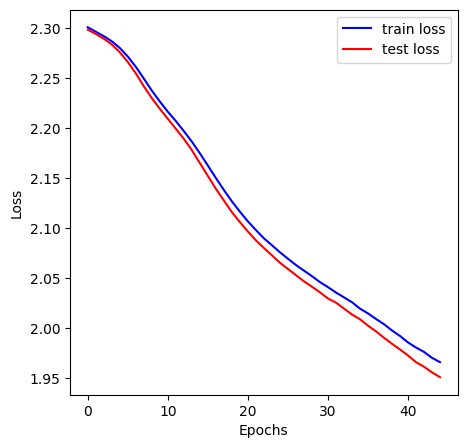

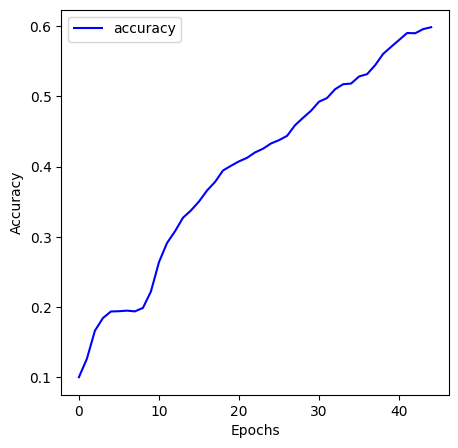

In [70]:
model11_o1 = NeuralNetwork11().to(device)
print(model11_o1)
count_parameters(model11_o1)
optimizer = torch.optim.Adam(model11_o1.parameters(), lr=1e-5, betas=(0.95, 0.99), weight_decay=1e-4)
results = train_model(model11_o1, loss_fn, optimizer, 45)

train_losses, test_losses, accuracy = results
plot_losses(train_losses, test_losses, "nn11-opt1")
plot_accuracy(accuracy, "nn11-opt1")